In [128]:
import pysam
import os
import sys
from sys import getsizeof
import time

directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, get_read_information, get_hamming_distance

from utils import get_intervals, index_bam, write_rows_to_info_file, write_header_to_bam, \
write_read_to_bam_file, remove_file_if_exists, make_folder

import os, psutil


# An example on a bam for 1500 cell barcodes (group0, group1, group2, group3, group4, group5, group6, group7 group8, group9, group10, group11 split from the original bam)

### Should be about 1500*30,000 = 45 million reads

#### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [129]:
bampath = '/projects/ps-yeolab3/ekofman/sailor2/data/groups_0_1_2_3_4_5_6_7_8_9_10_11_merged.bam'
samfile = pysam.AlignmentFile(bampath, "rb")

In [130]:
samfile_header = str(samfile.header)

In [131]:
getsizeof(samfile_header)/1000

19338.323

# Helper functions

In [132]:
def find_edits(bampath, contig, split_index, start, end, output_folder, verbose=False):
    time_reporting = {}
    start_time = time.perf_counter()
    
    samfile = pysam.AlignmentFile(bampath, "rb")
        
    counts = defaultdict(lambda:defaultdict(lambda:0))
    total_reads = 0
    
    bam_handles_for_barcodes = {}
    read_lists_for_barcodes = defaultdict(lambda:[])
    
    reads_for_contig = samfile.fetch(contig, start, end, multiple_iterators=True)

    output_file = '{}/{}_{}_{}_{}_edit_info.tsv'.format(edit_info_subfolder, contig, split_index, start, end)
    remove_file_if_exists(output_file)

    with open(output_file, 'w') as f:        
        write_header_to_bam(f)

        for i, read in enumerate(reads_for_contig):
            total_reads += 1
            
            if total_reads % 1000 == 0:
                time_reporting[total_reads] = time.perf_counter() - start_time

            barcode = read.get_tag("CB")
            barcodes[contig][barcode] += 1

            error_code, list_of_rows, num_edits_of_each_type = get_read_information(read, contig, verbose=verbose)

            if error_code:
                counts[contig][error_code] += 1
            else:
                counts[contig][EDITED_CODE] += 1
                write_rows_to_info_file(list_of_rows, f)
            
            # Store each read using its string representation
            read_lists_for_barcodes[barcode].append(read.to_string())
            
    
    # Add all reads to dictionary for contig and barcode, in their string representation
    num_barcodes = 0
    total_bams = len(read_lists_for_barcodes)
    
    barcode_to_concatted_reads = {}
    for barcode, read_list in read_lists_for_barcodes.items():
        num_barcodes += 1
        if num_barcodes % 100 == 0:
            print('{}/{} processed'.format(num_barcodes, total_bams))
        
        # Concatenate the string representations of all reads for each bam-contig combination
        all_reads_concatted = '\n'.join(read_list)
        
        # Save this concatenated block of text to dictionary
        barcode_to_concatted_reads[barcode] = all_reads_concatted
        
    time_reporting[total_reads] = time.perf_counter() - start_time
    
    samfile.close()
    
    return barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting


def find_edits_and_split_bams(bampath, contig, split_index, start, end, output_folder, verbose=False):
    barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting = find_edits(bampath, contig, split_index,
                                                                         start, end, output_folder, verbose=verbose)    
    return barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting
    
def find_edits_and_split_bams_wrapper(parameters):
    try:
        start_time = time.perf_counter()
        bampath, contig, split_index, start, end, output_folder, verbose = parameters
        label = '{}({}):{}-{}'.format(contig, split_index, start, end)

        #print("{} ({}):{}-{}\tfind_edits_and_split_bams".format(contig, split_index, start, end))
        barcode_to_concatted_reads, total_reads, barcodes, counts, time_reporting = find_edits_and_split_bams(bampath, contig, split_index, start, end, output_folder, verbose=False)
        barcodes_df = pd.DataFrame.from_dict(barcodes)
        counts_df = pd.DataFrame.from_dict(counts)
        time_df = pd.DataFrame.from_dict(time_reporting, orient='index')
        barcode_to_concatted_reads_df = pd.DataFrame.from_dict(barcode_to_concatted_reads, orient='index')
        
        total_time = time.perf_counter() - start_time
        return barcode_to_concatted_reads_df, total_reads, barcodes_df, label, counts_df, time_df, total_time
    except Exception as e:
        print('Contig {}: {}'.format(label, e))
        return 0, pd.DataFrame(), label, pd.DataFrame()

# Go through every read and identify all edits

In [133]:
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm

start_time = time.perf_counter()

print("CPU count: {}".format(multiprocessing.cpu_count()))

output_folder = '/projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger'

contig_lengths_dict = get_contig_lengths_dict(samfile)

# Print info?
verbose = False 
EDITED_CODE = 'edited'

# How many subcontigs to split each contig into to leverage multi-processing
num_intervals = 16

num_reads_to_coverage_dict_kb = {}
num_reads_to_seconds = {}


start_time = time.perf_counter()
total_seconds_for_reads = {0: 1}

barcodes = defaultdict(lambda:defaultdict(lambda:0))

jobs = []
for contig in contig_lengths_dict.keys():

    if len(contig) > 5 or contig == 'Stamp':
        continue
        
    print("Contig {}".format(contig))
    contig_length = contig_lengths_dict.get(contig)
    intervals_for_contig = get_intervals(contig, contig_lengths_dict, num_intervals)
    
    # Make subfolder in which to information about edits
    edit_info_subfolder = '{}/edit_info'.format(output_folder)
    make_folder(edit_info_subfolder)
        
    # Set up for pool
    for split_index, interval in enumerate(intervals_for_contig):
        split_index = str(split_index).zfill(3)
        parameters = [bampath, contig, split_index, interval[0], interval[1], output_folder, verbose]
        jobs.append(parameters)
    
print("{} total jobs".format(len(jobs)))

# Pooling

results = []
overall_total_reads = 0
with Pool(processes=16) as p:
    max_ = len(jobs)
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(find_edits_and_split_bams_wrapper, jobs):
            pbar.update()
            results.append(_)
            
            total_reads = _[1]
            total_time = time.perf_counter() - start_time

            overall_total_reads += total_reads
            total_seconds_for_reads[overall_total_reads] = total_time

overall_time = time.perf_counter() - start_time 


CPU count: 36
Contig 1
Contig 10
Contig 11
Contig 12
Contig 13
Contig 14
Contig 15
Contig 16
Contig 17
Contig 18
Contig 19
Contig 2
Contig 3
Contig 4
Contig 5
Contig 6
Contig 7
Contig 8
Contig 9
Contig MT
Contig X
Contig Y
352 total jobs


  0%|          | 0/352 [00:00<?, ?it/s]

100/1180 processed
200/1180 processed100/1404 processed

300/1180 processed200/1404 processed

300/1404 processed400/1180 processed
400/1404 processed

500/1404 processed500/1180 processed100/1447 processed


100/1458 processed100/1474 processed
600/1404 processed
700/1404 processed200/1474 processed
200/1447 processed

300/1474 processed300/1447 processed

400/1447 processed
500/1447 processed
600/1447 processed
400/1474 processed200/1458 processed
100/1448 processed300/1458 processed
200/1448 processed

800/1404 processed
400/1458 processed900/1404 processed
1000/1404 processed
1100/1404 processed
1200/1404 processed
1300/1404 processed
1400/1404 processed
700/1447 processed
800/1447 processed

100/1482 processed600/1180 processed

900/1447 processed
1000/1447 processed
1100/1447 processed
1200/1447 processed
1300/1447 processed500/1458 processed
300/1448 processed
400/1448 processed
500/1448 processed

600/1448 processed
700/1180 processed
800/1180 processed
900/1180 processed
1000/

  0%|          | 1/352 [00:01<07:43,  1.32s/it]

700/1482 processed
800/1482 processed
900/1482 processed
1000/1482 processed
1100/1482 processed
1200/1482 processed
1200/1448 processed

800/1448 processed
900/1448 processed
1000/1448 processed
1100/1448 processed800/1458 processed
1300/1482 processed1300/1448 processed
900/1458 processed


1400/1448 processed
1400/1482 processed1100/1474 processed


1000/1458 processed

  1%|▏         | 5/352 [00:01<01:16,  4.52it/s]

1200/1474 processed

1300/1474 processed1100/1458 processed

1400/1474 processed
1200/1458 processed
1300/1458 processed
1400/1458 processed
100/1494 processed

200/1494 processed
300/1494 processed
400/1494 processed500/1494 processed
600/1494 processed
700/1494 processed
800/1494 processed
900/1494 processed
1000/1494 processed
1100/1494 processed
1200/1494 processed
1300/1494 processed
1400/1494 processed


  2%|▏         | 8/352 [00:01<00:50,  6.88it/s]

100/1488 processed
200/1488 processed
300/1488 processed
400/1488 processed
500/1488 processed
600/1488 processed
700/1488 processed100/1489 processed
800/1488 processed
900/1488 processed
1000/1488 processed
1100/1488 processed
1200/1488 processed
1300/1488 processed

1400/1488 processed
200/1489 processed100/1367 processed

200/1367 processed100/1498 processed
200/1498 processed
300/1489 processed
300/1367 processed
400/1367 processed
500/1367 processed
600/1367 processed300/1498 processed

700/1367 processed
400/1489 processed800/1367 processed
400/1498 processed
500/1498 processed

600/1498 processed
900/1367 processed500/1489 processed

600/1489 processed
700/1489 processed
800/1489 processed
900/1489 processed
700/1498 processed
800/1498 processed
900/1498 processed

1000/1498 processed
1100/1498 processed
1200/1498 processed
1000/1489 processed
1300/1498 processed1000/1367 processed
1100/1367 processed100/1384 processed
200/1384 processed
300/1384 processed
400/1384 processed

1

  3%|▎         | 10/352 [00:01<00:43,  7.83it/s]

1400/1489 processed
700/1495 processed
800/1495 processed
900/1495 processed100/1500 processed

1000/1495 processed200/1500 processed

1100/1495 processed
1200/1495 processed300/1500 processed

400/1500 processed
500/1500 processed
600/1500 processed
1300/1495 processed700/1500 processed
800/1500 processed
900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed

1400/1495 processed
1400/1500 processed
100/1455 processed1500/1500 processed



  4%|▎         | 13/352 [00:01<00:31, 10.88it/s]

100/1341 processed200/1455 processed
300/1455 processed100/1486 processed
400/1455 processed
500/1455 processed
600/1455 processed
700/1455 processed
800/1455 processed

900/1455 processed

1000/1455 processed200/1341 processed200/1486 processed


1100/1455 processed
300/1341 processed1200/1455 processed
300/1486 processed1300/1455 processed


400/1341 processed
400/1486 processed500/1341 processed
1400/1455 processed
500/1486 processed

600/1341 processed
600/1486 processed
700/1341 processed
700/1486 processed1200/1266 processed
800/1341 processed
800/1486 processed
900/1341 processed
900/1486 processed
1000/1341 processed
1000/1486 processed
1100/1486 processed1100/1341 processed

1200/1486 processed1200/1341 processed
1300/1486 processed

1300/1341 processed1400/1486 processed

100/1266 processed
200/1266 processed
300/1266 processed
400/1266 processed
500/1266 processed
600/1266 processed
700/1266 processed
800/1266 processed
900/1266 processed
1000/1266 processed
1100/1266 proces

  5%|▍         | 17/352 [00:02<00:22, 15.08it/s]

800/1406 processed
900/1406 processed
1000/1406 processed
1100/1406 processed
1200/1406 processed

1300/1406 processed700/1442 processed
1400/1406 processed
800/1442 processed
900/1442 processed
1000/1442 processed
100/1498 processed1100/1442 processed

1200/1442 processed200/1498 processed

1300/1442 processed100/566 processed
300/1498 processed1400/1442 processed


200/566 processed400/1498 processed


  6%|▌         | 21/352 [00:02<00:19, 16.57it/s]


300/566 processed500/1498 processed
100/1499 processed

400/566 processed600/1498 processed

200/1499 processed500/566 processed700/1498 processed


300/1499 processed800/1498 processed

400/1499 processed900/1498 processed100/1463 processed

500/1499 processed
1000/1498 processed200/1463 processed


600/1499 processed
700/1499 processed100/1406 processed

1100/1498 processed800/1499 processed
200/1406 processed
900/1499 processed300/1463 processed

400/1463 processed
500/1463 processed
600/1463 processed
1000/1499 processed700/1463 processed

800/1463 processed1100/1499 processed

900/1463 processed
1200/1499 processed
1000/1463 processed

1100/1463 processed300/1406 processed
400/1406 processed
500/1406 processed
600/1406 processed
700/1406 processed
800/1406 processed
900/1406 processed
1000/1406 processed
1100/1406 processed
1300/1499 processed1200/1498 processed

1400/1499 processed1300/1498 processed

1400/1498 processed
1200/1406 processed

1300/1406 processed
1400/1406 process

  7%|▋         | 24/352 [00:02<00:24, 13.47it/s]


500/1466 processed
600/1466 processed
700/1466 processed
800/1466 processed

900/1466 processed
1000/1466 processed
1100/1466 processed100/1464 processed1200/1466 processed

200/1464 processed1300/1466 processed

1400/1466 processed
300/1464 processed
400/1464 processed
500/1464 processed100/1335 processed

600/1464 processed
700/1464 processed
800/1464 processed
900/1464 processed
200/1335 processed
1000/1464 processed300/1335 processed

400/1335 processed
500/1335 processed1100/1464 processed
600/1335 processed

1200/1464 processed700/1335 processed


  8%|▊         | 27/352 [00:02<00:23, 13.98it/s]

800/1335 processed

1300/1464 processed900/1335 processed

100/1492 processed1000/1335 processed100/1487 processed


1400/1464 processed1100/1335 processed
200/1487 processed200/1492 processed


1200/1335 processed
1300/1335 processed300/1487 processed


300/1492 processed400/1487 processed
500/1487 processed400/1492 processed

600/1487 processed
700/1487 processed500/1492 processed
100/1498 processed800/1487 processed

900/1487 processed600/1492 processed

700/1492 processed

800/1492 processed1000/1487 processed

1100/1487 processed900/1492 processed200/1498 processed


1000/1492 processed1200/1487 processed300/1498 processed


1300/1487 processed
1100/1492 processed400/1498 processed
1400/1487 processed1200/1492 processed

1300/1492 processed

100/1488 processed500/1498 processed
1400/1492 processed

200/1488 processed

  9%|▊         | 30/352 [00:02<00:20, 16.01it/s]

600/1498 processed

300/1488 processed
400/1488 processed
500/1488 processed
700/1498 processed600/1488 processed

800/1498 processed700/1488 processed

800/1488 processed
900/1498 processed
900/1488 processed
1000/1498 processed1000/1488 processed

1100/1488 processed1100/1498 processed

1200/1488 processed
1200/1498 processed1300/1488 processed

1300/1498 processed1400/1488 processed

1400/1498 processed


  9%|▉         | 32/352 [00:03<00:20, 15.97it/s]

100/1497 processed
200/1497 processed
300/1497 processed
400/1497 processed
500/1497 processed
600/1497 processed
700/1497 processed
800/1497 processed
900/1497 processed
1000/1497 processed
1100/1497 processed
1200/1497 processed
1300/1497 processed
1400/1497 processed


 10%|▉         | 34/352 [00:03<00:22, 14.01it/s]

100/1492 processed
200/1492 processed
300/1492 processed
100/1498 processed400/1492 processed

500/1492 processed
600/1492 processed
700/1492 processed
200/1498 processed
300/1498 processed
400/1498 processed
800/1492 processed500/1498 processed
900/1492 processed

1000/1492 processed
1100/1492 processed
1200/1492 processed600/1498 processed

1300/1492 processed
1400/1492 processed100/1448 processed
700/1498 processed

200/1448 processed800/1498 processed
900/1498 processed
1000/1498 processed
1100/1498 processed
1200/1498 processed
1300/1498 processed
1400/1498 processed
100/1500 processed
300/1448 processed
400/1448 processed
500/1448 processed
600/1448 processed
700/1448 processed
800/1448 processed
900/1448 processed

1000/1448 processed
1100/1448 processed
1200/1448 processed
1300/1448 processed
1400/1448 processed
200/1500 processed
100/1499 processed

 10%|█         | 36/352 [00:03<00:33,  9.42it/s]

300/1500 processed100/1498 processed


200/1499 processed400/1500 processed200/1498 processed


300/1499 processed500/1500 processed300/1498 processed


600/1500 processed400/1499 processed400/1498 processed


700/1500 processed500/1499 processed500/1498 processed
800/1500 processed
900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed
100/1407 processed600/1498 processed
200/1407 processed
300/1407 processed
400/1407 processed
500/1407 processed

600/1499 processed
700/1499 processed

700/1498 processed

800/1498 processed
1400/1500 processed
800/1499 processed1500/1500 processed600/1407 processed

900/1498 processed900/1499 processed

1000/1498 processed100/1440 processed700/1407 processed
1000/1499 processed



1100/1498 processed200/1440 processed

 11%|█         | 38/352 [00:03<00:33,  9.29it/s]

800/1407 processed

1100/1499 processed

900/1407 processed
1200/1498 processed1000/1407 processed1200/1499 processed



1100/1407 processed1300/1499 processed1200/1407 processed

1300/1407 processed1400/1499 processed

300/1440 processed1300/1498 processed1400/1407 processed100/1497 processed



400/1440 processed1400/1498 processed

500/1440 processed200/1497 processed
300/1497 processed

400/1497 processed
500/1497 processed
600/1497 processed
700/1497 processed
800/1497 processed
600/1440 processed
900/1497 processed700/1440 processed
1000/1497 processed

800/1440 processed
900/1440 processed
1000/1440 processed
1100/1440 processed1100/1497 processed
1200/1440 processed
1200/1497 processed


 12%|█▏        | 41/352 [00:03<00:26, 11.89it/s]

1300/1497 processed

1300/1440 processed
1400/1440 processed
1400/1497 processed
100/1390 processed
200/1390 processed
300/1390 processed
100/1497 processed400/1390 processed100/1419 processed

100/1457 processed

200/1457 processed100/1498 processed200/1419 processed500/1390 processed
600/1390 processed
700/1390 processed

800/1390 processed200/1498 processed

 12%|█▏        | 43/352 [00:04<00:25, 12.03it/s]

200/1497 processed




300/1457 processed300/1419 processed900/1390 processed

400/1419 processed400/1457 processed
300/1498 processed
300/1497 processed500/1419 processed

500/1457 processed
600/1457 processed
700/1457 processed400/1498 processed400/1497 processed

800/1457 processed
900/1457 processed
500/1497 processed1000/1457 processed

1100/1457 processed
600/1497 processed1200/1457 processed


1300/1457 processed
700/1497 processed1400/1457 processed
500/1498 processed
800/1497 processed600/1498 processed

900/1497 processed700/1498 processed

1000/1390 processed

1100/1390 processed
1200/1390 processed800/1498 processed

900/1498 processed
1000/1498 processed
1100/1498 processed

600/1419 processed
700/1419 processed
800/1419 processed1200/1498 processed
900/1419 processed
1000/1419 processed
1100/1419 processed
1200/1419 processed
1300/1419 processed1000/1497 processed
1400/1419 processed



1300/1498 processed1300/1390 processed1100/1497 processed


1400/1498 processed1200/14

 13%|█▎        | 47/352 [00:04<00:19, 15.47it/s]


600/1500 processed100/1249 processed
700/1500 processed

800/1500 processed200/1249 processed100/1427 processed


300/1249 processed200/1427 processed
400/1249 processed

500/1249 processed300/1427 processed

600/1249 processed100/1277 processed

400/1427 processed700/1249 processed200/1277 processed

300/1277 processed
400/1277 processed
900/1500 processed500/1277 processed

600/1277 processed1000/1500 processed

700/1277 processed
1100/1500 processed
800/1277 processed
1200/1500 processed900/1277 processed

1000/1277 processed1300/1500 processed

1100/1277 processed
1200/1277 processed1400/1500 processed

800/1249 processed
900/1249 processed
1000/1249 processed
1100/1249 processed
1200/1249 processed

500/1427 processed

600/1427 processed

 14%|█▍        | 49/352 [00:04<00:21, 14.40it/s]


700/1427 processed
800/1427 processed1500/1500 processed
900/1427 processed

1000/1427 processed
1100/1427 processed
1200/1427 processed1300/1427 processed
1400/1427 processed
100/975 processed
200/975 processed
300/975 processed
400/975 processed
500/975 processed
600/975 processed
700/975 processed
800/975 processed
900/975 processed
100/1454 processed
200/1454 processed
300/1454 processed
400/1454 processed
500/1454 processed
600/1454 processed
700/1454 processed
800/1454 processed
900/1454 processed
1000/1454 processed
1100/1454 processed
1200/1454 processed
1300/1454 processed
1400/1454 processed
100/1500 processed


 15%|█▌        | 53/352 [00:04<00:17, 17.09it/s]

200/1500 processed
300/1500 processed100/1132 processed
200/1132 processed

300/1132 processed400/1500 processed
500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed
900/1500 processed

1000/1500 processed400/1132 processed
500/1132 processed
600/1132 processed
700/1132 processed
800/1132 processed
900/1132 processed
1000/1132 processed
1100/1132 processed

100/1344 processed1100/1500 processed

200/1344 processed
300/1344 processed
400/1344 processed
1200/1500 processed500/1344 processed

1300/1500 processed600/1344 processed100/1326 processed
100/1500 processed
700/1344 processed
800/1344 processed
900/1344 processed
200/1500 processed

200/1326 processed
1000/1344 processed1400/1500 processed300/1500 processed
400/1500 processed
500/1500 processed
600/1500 processed

700/1500 processed
800/1500 processed
900/1500 processed100/1402 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed30

 16%|█▌        | 56/352 [00:05<00:25, 11.83it/s]

1200/1402 processed
1300/1402 processed
1400/1402 processed
100/1484 processed
200/1484 processed
300/1484 processed
400/1484 processed
500/1484 processed
600/1484 processed
700/1484 processed
800/1484 processed
900/1484 processed
1000/1484 processed
1100/1484 processed
1200/1484 processed
1300/1484 processed
1400/1484 processed
100/1445 processed
200/1445 processed
300/1445 processed
400/1445 processed
500/1445 processed
600/1445 processed
700/1445 processed
800/1445 processed
900/1445 processed

 17%|█▋        | 60/352 [00:05<00:18, 15.58it/s]


1000/1445 processed100/1433 processed

1100/1445 processed
200/1433 processed1200/1445 processed

300/1433 processed1300/1445 processed
1400/1445 processed

400/1433 processed
500/1433 processed
600/1433 processed
700/1433 processed
800/1433 processed
100/1500 processed
900/1433 processed200/1500 processed
100/1497 processed300/1500 processed

400/1500 processed
200/1497 processed
500/1500 processed
300/1497 processed
600/1500 processed400/1497 processed
500/1497 processed
100/1465 processed

1000/1433 processed
1100/1433 processed
1200/1433 processed
1300/1433 processed
1400/1433 processed

600/1497 processed100/1500 processed
200/1465 processed700/1500 processed

300/1465 processed700/1497 processed

200/1500 processed

300/1500 processed

 18%|█▊        | 63/352 [00:05<00:17, 16.29it/s]



800/1500 processed
800/1497 processed
400/1500 processed
900/1497 processed1000/1497 processed
500/1500 processed1100/1497 processed

1200/1497 processed
1300/1497 processed600/1500 processed

1400/1497 processed400/1465 processed

700/1500 processed
500/1465 processed
800/1500 processed600/1465 processed

700/1465 processed
800/1465 processed
900/1500 processed
900/1500 processed1000/1500 processed900/1465 processed


1000/1500 processed1100/1500 processed1000/1465 processed


1200/1500 processed
1100/1465 processed1300/1500 processed
1100/1500 processed

1200/1465 processed1400/1500 processed

1300/1465 processed1500/1500 processed
1200/1500 processed1400/1465 processed


1300/1500 processed100/1269 processed

200/1269 processed
100/1497 processed100/1393 processed1400/1500 processed300/1269 processed


1500/1500 processed

400/1269 processed
200/1393 processed500/1269 processed
600/1269 processed
200/1497 processed
700/1269 processed
800/1269 processed
900/1269 processed
1000/1269

 19%|█▉        | 66/352 [00:05<00:18, 15.73it/s]

300/1473 processed


800/1497 processed400/1473 processed300/1393 processed


400/1393 processed900/1497 processed500/1473 processed
500/1393 processed
600/1393 processed
700/1393 processed
800/1393 processed
900/1393 processed

100/1456 processed

600/1473 processed
1000/1497 processed

700/1473 processed200/1456 processed
1100/1497 processed800/1473 processed1000/1393 processed300/1456 processed
1100/1393 processed
1200/1393 processed
1300/1393 processed


400/1456 processed
500/1456 processed

 20%|█▉        | 69/352 [00:05<00:15, 18.12it/s]


600/1456 processed
1200/1497 processed700/1456 processed
800/1456 processed
900/1456 processed
1000/1456 processed
1100/1456 processed
1200/1456 processed
100/1500 processed1300/1456 processed
900/1473 processed
1000/1473 processed
1100/1473 processed
1200/1473 processed

1300/1473 processed1400/1456 processed

1400/1473 processed

1300/1497 processed
1400/1497 processed

200/1500 processed


 21%|██        | 73/352 [00:05<00:12, 21.70it/s]

300/1500 processed
400/1500 processed100/1392 processed
100/1450 processed
500/1500 processed

200/1392 processed200/1450 processed100/1482 processed600/1500 processed


300/1392 processed300/1450 processed700/1500 processed


200/1482 processed
800/1500 processed400/1392 processed
400/1450 processed

900/1500 processed
500/1392 processed1000/1500 processed
500/1450 processed


600/1392 processed600/1450 processed300/1482 processed


1100/1500 processed700/1392 processed400/1482 processed700/1450 processed


800/1450 processed
1200/1500 processed
500/1482 processed800/1392 processed
900/1450 processed600/1482 processed

1000/1450 processed700/1482 processed

1100/1450 processed
800/1482 processed1200/1450 processed

100/1423 processed900/1482 processed

1300/1450 processed200/1423 processed
1000/1482 processed
1400/1450 processed
1100/1482 processed
300/1423 processed

1200/1482 processed1300/1500 processed
400/1423 processed
1300/1482 processed


1400/1500 processed1400/1482 processed

 22%|██▏       | 76/352 [00:06<00:17, 15.34it/s]

100/1500 processed
100/1484 processed

1100/1423 processed100/1339 processed

200/1484 processed200/1500 processed1200/1423 processed


200/1339 processed300/1484 processed

1300/1423 processed300/1339 processed
400/1484 processed400/1339 processed

300/1500 processed500/1484 processed

500/1339 processed
600/1484 processed600/1339 processed

700/1484 processed
700/1339 processed
800/1484 processed800/1339 processed


900/1484 processed
900/1339 processed
1000/1484 processed1000/1339 processed

1100/1484 processed1100/1339 processed

1200/1339 processed1200/1484 processed

1300/1339 processed1300/1484 processed

1400/1484 processed400/1500 processed

1400/1423 processed
500/1500 processed100/1497 processed

200/1497 processed
600/1500 processed300/1497 processed
400/1497 processed

500/1497 processed700/1500 processed
800/1500 processed
900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed

1300/1500 processed
1400/1500 processed
1500/1500 processed

600/1497 p

 22%|██▏       | 79/352 [00:06<00:17, 15.82it/s]

100/1497 processed
200/1497 processed


 24%|██▎       | 83/352 [00:06<00:13, 19.22it/s]

300/1497 processed
400/1497 processed
500/1497 processed
600/1497 processed
700/1497 processed
800/1497 processed
900/1497 processed
1000/1497 processed
1100/1497 processed
1200/1497 processed
1300/1497 processed
1400/1497 processed
100/670 processed
200/670 processed
300/670 processed
400/670 processed
500/670 processed
600/670 processed
100/1300 processed
200/1300 processed
300/1300 processed
400/1300 processed
500/1300 processed
600/1300 processed
700/1300 processed100/1478 processed100/1049 processed
200/1049 processed
300/1049 processed
400/1049 processed
500/1049 processed

100/1499 processed
800/1300 processed600/1049 processed
200/1478 processed200/1499 processed
300/1499 processed
300/1478 processed

900/1300 processed400/1478 processed100/638 processed100/1494 processed


200/638 processed


400/1499 processed700/1049 processed1000/1300 processed



500/1478 processed500/1499 processed800/1049 processed
200/1494 processed
1100/1300 processed300/638 processed

600/1499 process

 24%|██▍       | 86/352 [00:06<00:15, 16.85it/s]



600/1478 processed600/638 processed1200/1499 processed
500/1494 processed


700/1478 processed1300/1499 processed

1400/1499 processed600/1494 processed800/1478 processed


700/1494 processed900/1478 processed

1000/1478 processed800/1494 processed

1100/1478 processed100/1408 processed
900/1494 processed1200/1478 processed
1300/1478 processed
1400/1478 processed

200/1408 processed
300/1408 processed
400/1408 processed
500/1408 processed
600/1408 processed
700/1408 processed
800/1408 processed
900/1408 processed
100/1163 processed900/1163 processed1000/1408 processed

1100/1408 processed
1200/1408 processed
1300/1408 processed
1400/1408 processed

1000/1494 processed
200/1163 processed
300/1163 processed
400/1163 processed
500/1163 processed
600/1163 processed
700/1163 processed
800/1163 processed

1000/1163 processed
1100/1163 processed
1100/1494 processed


 26%|██▌       | 91/352 [00:06<00:11, 22.33it/s]

1200/1494 processed
1300/1494 processed
1400/1494 processed
100/1494 processed
200/1494 processed100/1496 processed100/1352 processed


200/1496 processed300/1494 processed100/1094 processed200/1352 processed



200/1094 processed300/1352 processed

400/1494 processed300/1094 processed400/1352 processed300/1496 processed

100/1452 processed
500/1352 processed


200/1452 processed500/1494 processed
600/1352 processed
400/1496 processed400/1094 processed
600/1494 processed

700/1494 processed500/1094 processed500/1496 processed

600/1094 processed
700/1094 processed
300/1452 processed800/1094 processed

900/1094 processed400/1452 processed

1000/1094 processed
500/1452 processed
600/1452 processed
700/1452 processed
800/1494 processed800/1452 processed

900/1494 processed900/1452 processed



1000/1452 processed
1100/1452 processed600/1496 processed

700/1496 processed
1200/1452 processed800/1496 processed

 27%|██▋       | 94/352 [00:06<00:13, 19.37it/s]



1000/1494 processed
1100/1494 processed900/1496 processed
1000/1496 processed
1100/1496 processed
1200/1496 processed
1300/1496 processed100/1370 processed

1400/1496 processed1300/1452 processed700/1352 processed
200/1370 processed


800/1352 processed

300/1370 processed1400/1452 processed900/1352 processed
400/1370 processed
500/1370 processed

1200/1494 processed
100/1376 processed
1300/1494 processed1000/1352 processed100/1458 processed


1100/1352 processed
200/1458 processed
1400/1494 processed

300/1458 processed
400/1458 processed
500/1458 processed
600/1370 processed600/1458 processed1200/1352 processed

200/1376 processed
100/1398 processed700/1458 processed
1300/1352 processed

100/1310 processed800/1458 processed
300/1376 processed200/1398 processed


900/1458 processed200/1310 processed
400/1376 processed1000/1458 processed


300/1310 processed500/1376 processed
1100/1458 processed

400/1310 processed600/1376 processed
1200/1458 processed

500/1310 processed700/1376 pro

 28%|██▊       | 97/352 [00:07<00:12, 20.40it/s]

100/1495 processed
200/1495 processed
300/1495 processed
100/1285 processed
400/1495 processed
200/1285 processed
300/1285 processed500/1495 processed

400/1285 processed600/1495 processed
100/1429 processed

700/1495 processed500/1285 processed

200/1429 processed
800/1495 processed600/1285 processed300/1429 processed
700/1285 processed
400/1429 processed
500/1429 processed
600/1429 processed
700/1429 processed
900/1495 processed
1000/1495 processed
1100/1495 processed
1200/1495 processed
1300/1495 processed
1400/1495 processed

800/1429 processed
900/1429 processed

800/1285 processed1000/1429 processed

1100/1429 processed
1200/1429 processed
1300/1429 processed


 30%|██▉       | 104/352 [00:07<00:08, 28.83it/s]

900/1285 processed
1400/1429 processed
1000/1285 processed
1100/1285 processed
1200/1285 processed
100/1078 processed
100/1454 processed
200/1454 processed
100/1420 processed
100/1199 processed
200/1078 processed300/1454 processed200/1420 processed
300/1420 processed
400/1420 processed
500/1420 processed
600/1420 processed
700/1420 processed
800/1420 processed
900/1420 processed
1000/1420 processed

300/1078 processed
400/1078 processed
500/1078 processed
600/1078 processed
700/1078 processed
800/1078 processed
900/1078 processed
1000/1078 processed

400/1454 processed200/1199 processed1100/1420 processed


300/1199 processed500/1454 processed1200/1420 processed
1300/1420 processed
1400/1420 processed100/1448 processed
200/1448 processed
300/1448 processed
400/1448 processed
500/1448 processed
600/1448 processed
700/1448 processed
800/1448 processed
900/1448 processed
1000/1448 processed
1100/1448 processed
1200/1448 processed
1300/1448 processed
1400/1448 processed



600/1454 process

 31%|███       | 108/352 [00:07<00:14, 16.82it/s]

400/1199 processed
700/1454 processed
800/1454 processed
900/1454 processed
1000/1454 processed
1100/1454 processed
1200/1454 processed
1300/1454 processed
1400/1454 processed

500/1199 processed
600/1199 processed
700/1199 processed100/1496 processed
200/1496 processed
300/1496 processed
800/1199 processed
900/1199 processed
1000/1199 processed
1100/1199 processed

400/1496 processed

 32%|███▏      | 111/352 [00:07<00:13, 18.16it/s]


100/1457 processed100/756 processed100/1450 processed500/1496 processed


600/1496 processed200/1450 processed
200/1457 processed


300/1450 processed200/756 processed
300/1457 processed
700/1496 processed
300/756 processed

400/756 processed800/1496 processed400/1457 processed


900/1496 processed500/1457 processed500/756 processed


1000/1496 processed600/756 processed

700/756 processed600/1457 processed400/1450 processed
1100/1496 processed


500/1450 processed1200/1496 processed

700/1457 processed1300/1496 processed

600/1450 processed800/1457 processed1400/1496 processed


700/1450 processed
800/1450 processed
900/1450 processed
1000/1450 processed
1100/1450 processed
1200/1450 processed
1300/1450 processed
1400/1450 processed
100/986 processed900/1457 processed

200/986 processed
1000/1457 processed
1100/1457 processed
1200/1457 processed
1300/1457 processed
1400/1457 processed
300/986 processed
400/986 processed
500/986 processed
600/986 processed
700/986 processed
800/986 pr

 32%|███▏      | 114/352 [00:08<00:12, 18.83it/s]

100/1498 processed
200/1498 processed
300/1498 processed
400/1498 processed
500/1498 processed
600/1498 processed
700/1498 processed
800/1498 processed100/1287 processed

900/1498 processed200/1287 processed

1000/1498 processed300/1287 processed

1100/1498 processed400/1287 processed

1200/1498 processed500/1287 processed

1300/1498 processed600/1287 processed

1400/1498 processed700/1287 processed

800/1287 processed
900/1287 processed
1000/1287 processed
100/1498 processed1100/1287 processed

 33%|███▎      | 117/352 [00:08<00:11, 19.88it/s]



1200/1287 processed200/1498 processed100/950 processed


300/1498 processed200/950 processed

400/1498 processed300/950 processed100/1226 processed


100/1496 processed400/950 processed500/1498 processed200/1226 processed100/1489 processed

200/1496 processed
300/1496 processed

400/1496 processed600/1498 processed

200/1489 processed

700/1498 processed
800/1498 processed300/1226 processed
300/1489 processed
400/1489 processed

500/1496 processed
500/1489 processed
600/1489 processed
700/1489 processed
900/1498 processed800/1489 processed
500/950 processed
1000/1498 processed600/950 processed

700/950 processed1100/1498 processed

800/950 processed
1200/1498 processed900/950 processed


1300/1498 processed
900/1489 processed
1400/1498 processed
1000/1489 processed
1100/1489 processed
1200/1489 processed
1300/1489 processed600/1496 processed


1400/1489 processed400/1226 processed
700/1496 processed
800/1496 processed
900/1496 processed

1000/1496 processed
1100/1496 processed
1200/1

 34%|███▍      | 120/352 [00:08<00:13, 16.78it/s]

600/1226 processed
700/1226 processed
800/1226 processed
100/1473 processed900/1226 processed
100/1496 processed

200/1473 processed200/1496 processed
300/1496 processed
400/1496 processed1000/1226 processed
1100/1226 processed
1200/1226 processed
100/1434 processed
500/1496 processed

600/1496 processed

200/1434 processed300/1473 processed

700/1496 processed


 35%|███▍      | 123/352 [00:08<00:12, 17.84it/s]

400/1473 processed
300/1434 processed
500/1473 processed800/1496 processed

400/1434 processed900/1496 processed
500/1434 processed
600/1473 processed
1000/1496 processed600/1434 processed

1100/1496 processed700/1434 processed


1200/1496 processed700/1473 processed800/1434 processed


1300/1496 processed800/1473 processed900/1434 processed


1400/1496 processed900/1473 processed1000/1434 processed

1100/1434 processed100/1443 processed

1200/1434 processed

1000/1473 processed1300/1434 processed

1400/1434 processed1100/1473 processed
200/1443 processed

1200/1473 processed
1300/1473 processed
300/1443 processed1400/1473 processed
400/1443 processed100/1478 processed


200/1478 processed
300/1478 processed
500/1443 processed
400/1478 processed
600/1443 processed
500/1478 processed700/1443 processed

600/1478 processed

 36%|███▌      | 126/352 [00:08<00:11, 19.08it/s]

800/1443 processed

700/1478 processed900/1443 processed

1000/1443 processed800/1478 processed

1100/1443 processed900/1478 processed

1200/1443 processed
1000/1478 processed1300/1443 processed

1100/1478 processed1400/1443 processed

1200/1478 processed
1300/1478 processed
1400/1478 processed
100/1500 processed200/1500 processed100/1500 processed

100/1096 processed100/1422 processed
200/1500 processed

200/1422 processed
300/1500 processed
300/1500 processed
400/1500 processed
500/1500 processed200/1096 processed400/1500 processed
100/1228 processed

300/1096 processed
400/1096 processed
500/1096 processed200/1228 processed
300/1228 processed
300/1422 processed600/1500 processed

500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed

900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed
700/1500 processed400/1228 processed
500/1228 processed
600/1228 processed
700/1228 processe

 37%|███▋      | 129/352 [00:08<00:11, 19.17it/s]




700/1096 processed500/1422 processed
900/1500 processed
800/1096 processed600/1422 processed


900/1096 processed1000/1500 processed
100/815 processed700/1422 processed1000/1096 processed
200/815 processed
1100/1500 processed



800/1422 processed300/815 processed
1200/1500 processed
900/1422 processed

400/815 processed1000/1422 processed

1300/1500 processed500/815 processed

600/815 processed1400/1500 processed
1100/1422 processed
1500/1500 processed

700/815 processed1200/1422 processed
800/815 processed

1300/1422 processed
100/1383 processed1400/1422 processed
200/1383 processed

 38%|███▊      | 132/352 [00:09<00:14, 15.12it/s]



300/1383 processed
400/1383 processed
500/1383 processed
600/1383 processed
700/1383 processed
800/1383 processed
900/1383 processed
1000/1383 processed
1100/1383 processed
1200/1383 processed
1300/1383 processed
100/1310 processed
200/1310 processed
300/1310 processed
400/1310 processed
500/1310 processed
600/1310 processed100/1243 processed

700/1310 processed
800/1310 processed
900/1310 processed
1000/1310 processed
1100/1310 processed
1200/1310 processed
1300/1310 processed

200/1243 processed
300/1243 processed
400/1243 processed
500/1243 processed600/1243 processed
700/1243 processed
800/1243 processed
900/1243 processed
1000/1243 processed
1100/1243 processed

 38%|███▊      | 135/352 [00:09<00:12, 17.05it/s]


1200/1243 processed
100/1494 processed
200/1494 processed
300/1494 processed100/909 processed
200/909 processed
300/909 processed
400/909 processed
500/909 processed
600/909 processed
700/909 processed
800/909 processed

400/1494 processed
500/1494 processed
600/1494 processed
700/1494 processed
800/1494 processed
900/1494 processed
1000/1494 processed
1100/1494 processed
1200/1494 processed
1300/1494 processed
900/909 processed
1400/1494 processed
100/1407 processed100/1308 processed

200/1308 processed200/1407 processed

 39%|███▉      | 139/352 [00:09<00:10, 19.44it/s]


100/1498 processed
300/1308 processed

300/1407 processed400/1308 processed200/1498 processed


500/1308 processed400/1407 processed
300/1498 processed600/1308 processed


500/1407 processed700/1308 processed
400/1498 processed
800/1308 processed100/1369 processed100/1091 processed
200/1091 processed

300/1091 processed
400/1091 processed
900/1308 processed600/1407 processed
1000/1308 processed
200/1369 processed
1100/1308 processed100/1392 processed
200/1392 processed
300/1392 processed
500/1498 processed
300/1369 processed
400/1369 processed
500/1369 processed


700/1407 processed500/1091 processed

600/1091 processed
700/1091 processed
800/1091 processed
900/1091 processed

1200/1308 processed1000/1091 processed
1300/1308 processed
400/1392 processed
600/1369 processed


600/1498 processed700/1369 processed
500/1392 processed

900/1369 processed800/1369 processed600/1392 processed800/1407 processed
700/1498 processed100/1229 processed


700/1392 processed

1000/1369 processed800/14

 40%|████      | 142/352 [00:09<00:12, 16.53it/s]

100/1495 processed
200/1495 processed
300/1495 processed
400/1495 processed
500/1495 processed
600/1495 processed
100/1500 processed
700/1495 processed200/1500 processed

800/1495 processed
900/1495 processed
1000/1495 processed
1100/1495 processed
1200/1495 processed
1300/1495 processed300/1500 processed

1400/1495 processed400/1500 processed

500/1500 processed
600/1500 processed


 42%|████▏     | 148/352 [00:09<00:08, 24.29it/s]

700/1500 processed
800/1500 processed100/809 processed
900/1500 processed100/1488 processed100/851 processed


200/1488 processed

300/1488 processed
400/1488 processed
500/1488 processed
600/1488 processed
700/1488 processed
800/1488 processed
900/1488 processed
1000/1488 processed
1100/1488 processed
1200/1488 processed
1300/1488 processed
1400/1488 processed
1000/1500 processed200/851 processed200/809 processed


300/851 processed300/809 processed1100/1500 processed


400/851 processed1200/1500 processed400/809 processed

500/851 processed
500/809 processed

1300/1500 processed600/851 processed600/809 processed


700/851 processed700/809 processed1400/1500 processed


800/851 processed800/809 processed
1500/1500 processed

100/1013 processed
200/1013 processed
300/1013 processed
400/1013 processed
500/1013 processed
600/1013 processed
700/1013 processed
800/1013 processed
900/1013 processed
1000/1013 processed


 43%|████▎     | 152/352 [00:10<00:10, 19.29it/s]

100/1452 processed100/1170 processed

200/1170 processed200/1452 processed

300/1170 processed100/1367 processed300/1452 processed
400/1452 processed


500/1452 processed400/1170 processed
200/1367 processed600/1452 processed

700/1452 processed300/1367 processed100/1491 processed


200/1491 processed800/1452 processed400/1367 processed

500/1367 processed900/1452 processed
600/1367 processed

1000/1452 processed
700/1367 processed1100/1452 processed100/1188 processed100/1395 processed



1200/1452 processed500/1170 processed300/1491 processed

200/1395 processed1300/1452 processed
600/1170 processed1400/1452 processed



200/1188 processed800/1367 processed300/1395 processed




300/1188 processed900/1367 processed

400/1491 processed700/1170 processed1000/1367 processed400/1188 processed

1100/1367 processed100/1198 processed

200/1198 processed1200/1367 processed

300/1198 processed1300/1367 processed

400/1198 processed400/1395 processed


500/1188 processed
500/1198 processed

600

 44%|████▍     | 155/352 [00:10<00:11, 17.59it/s]



900/1198 processed1100/1170 processed
200/1482 processed
300/1482 processed



1000/1198 processed
1100/1198 processed400/1482 processed
500/1482 processed
600/1482 processed
700/1482 processed
800/1482 processed
900/1482 processed
1000/1482 processed
1100/1482 processed
1200/1482 processed
1300/1482 processed
1400/1482 processed


 46%|████▌     | 161/352 [00:10<00:07, 24.27it/s]

100/1195 processed100/1499 processed
100/1292 processed

200/1195 processed200/1292 processed200/1499 processed

100/1309 processed300/1195 processed

300/1499 processed
400/1499 processed
500/1499 processed

200/1309 processed
300/1309 processed
400/1309 processed
500/1309 processed
600/1309 processed
700/1309 processed
800/1309 processed
900/1309 processed400/1195 processed600/1499 processed300/1292 processed

100/1500 processed
700/1499 processed200/1500 processed

300/1500 processed
400/1500 processed
500/1500 processed
600/1500 processed
400/1292 processed1000/1309 processed
1100/1309 processed
1200/1309 processed
1300/1309 processed
800/1499 processed


500/1292 processed
700/1500 processed600/1292 processed

100/999 processed800/1500 processed
200/999 processed
700/1292 processed
300/999 processed900/1500 processed


800/1292 processed
400/999 processed
500/999 processed
100/1236 processed

600/999 processed
900/1292 processed700/999 processed
900/1499 processed1000/1292 process

 47%|████▋     | 165/352 [00:10<00:09, 19.80it/s]

800/1236 processed
900/1236 processed
1000/1236 processed
1100/1236 processed
1200/1236 processed
100/1414 processed
200/1414 processed
300/1414 processed
400/1414 processed
500/1414 processed
600/1414 processed
700/1414 processed
800/1414 processed
900/1414 processed
1000/1414 processed
1100/1414 processed
1200/1414 processed
1300/1414 processed
1400/1414 processed
100/1305 processed
200/1305 processed
300/1305 processed
400/1305 processed

 48%|████▊     | 168/352 [00:10<00:09, 20.34it/s]


500/1305 processed
600/1305 processed
700/1305 processed
800/1305 processed
900/1305 processed
1000/1305 processed
1100/1305 processed
1200/1305 processed
1300/1305 processed
100/1481 processed100/1478 processed

200/1478 processed200/1481 processed

300/1481 processed
300/1478 processed400/1481 processed

400/1478 processed500/1481 processed

500/1478 processed600/1481 processed

600/1478 processed700/1481 processed

700/1478 processed
800/1481 processed800/1478 processed

900/1481 processed900/1478 processed
1000/1481 processed
1100/1481 processed

1200/1481 processed
1300/1481 processed
1000/1478 processed1400/1481 processed

1100/1478 processed
1200/1478 processed
1300/1478 processed
1400/1478 processed


 49%|████▊     | 171/352 [00:11<00:10, 16.98it/s]

100/1406 processed
200/1406 processed
300/1406 processed
400/1406 processed100/1499 processed
500/1406 processed

200/1499 processed
600/1406 processed
700/1406 processed300/1499 processed
800/1406 processed

900/1406 processed400/1499 processed
1000/1406 processed
1100/1406 processed

500/1499 processed
1200/1406 processed600/1499 processed

700/1499 processed
1300/1406 processed
800/1499 processed1400/1406 processed

900/1499 processed
1000/1499 processed
1100/1499 processed100/1458 processed

200/1458 processed
1200/1499 processed300/1458 processed
1300/1499 processed100/1490 processed


100/1467 processed1400/1499 processed

200/1467 processed
400/1458 processed
300/1467 processed
500/1458 processed400/1467 processed
600/1458 processed
700/1458 processed
800/1458 processed
900/1458 processed200/1490 processed
300/1490 processed
400/1490 processed
500/1490 processed
600/1490 processed
700/1490 processed
800/1490 processed
900/1490 processed
1000/1490 processed
1100/1490 processed




 49%|████▉     | 174/352 [00:11<00:16, 10.73it/s]

1000/1467 processed200/1500 processed

1100/1467 processed300/1500 processed
400/1500 processed
500/1500 processed
600/1500 processed
700/1500 processed

800/1500 processed1200/1467 processed

1300/1467 processed900/1500 processed

1400/1467 processed1000/1500 processed

1100/1500 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed
100/1496 processed
200/1496 processed
300/1496 processed
400/1496 processed
500/1496 processed
600/1496 processed
700/1496 processed
100/1497 processed800/1496 processed
900/1496 processed
1000/1496 processed
1100/1496 processed
1200/1496 processed
1300/1496 processed
1400/1496 processed

200/1497 processed
300/1497 processed
400/1497 processed
500/1497 processed
600/1497 processed
700/1497 processed
800/1497 processed
900/1497 processed
1000/1497 processed
1100/1497 processed
1200/1497 processed
1300/1497 processed
1400/1497 processed
100/1298 processed


 51%|█████     | 178/352 [00:12<00:16, 10.51it/s]


200/1298 processed
300/1298 processed400/1298 processed
100/1498 processed500/1298 processed

600/1298 processed
700/1298 processed
800/1298 processed
900/1298 processed
1000/1298 processed200/1498 processed

100/1496 processed
1100/1298 processed300/1498 processed

1200/1298 processed100/1496 processed200/1496 processed
400/1498 processed

300/1496 processed

400/1496 processed200/1496 processed600/1498 processed


 51%|█████▏    | 181/352 [00:12<00:14, 11.81it/s]

300/1496 processed500/1498 processed

400/1496 processed
500/1496 processed

700/1498 processed
600/1496 processed800/1498 processed
900/1498 processed
1000/1498 processed
1100/1498 processed
1200/1498 processed

1300/1498 processed500/1496 processed

1400/1498 processed600/1496 processed

700/1496 processed

800/1496 processed
700/1496 processed900/1496 processed

1000/1496 processed800/1496 processed

900/1496 processed
1100/1496 processed1000/1496 processed
1100/1496 processed

1200/1496 processed1200/1496 processed

1300/1496 processed1300/1496 processed

1400/1496 processed1400/1496 processed



 52%|█████▏    | 183/352 [00:12<00:13, 12.54it/s]

100/1089 processed
100/1498 processed200/1089 processed

200/1498 processed
300/1089 processed300/1498 processed

400/1089 processed100/1498 processed100/1435 processed400/1498 processed

200/1498 processed

500/1498 processed
200/1435 processed300/1498 processed
600/1498 processed

500/1089 processed
400/1498 processed700/1498 processed
300/1435 processed
600/1089 processed
800/1498 processed100/1280 processed
200/1280 processed
300/1280 processed

500/1498 processed
600/1498 processed
700/1498 processed

900/1498 processed
1000/1498 processed700/1089 processed

800/1089 processed
900/1089 processed
1000/1089 processed
100/1435 processed400/1280 processed
500/1280 processed
600/1280 processed
700/1280 processed
800/1280 processed
900/1280 processed
1000/1280 processed
400/1435 processed



 53%|█████▎    | 185/352 [00:12<00:17,  9.54it/s]

500/1435 processed800/1498 processed1100/1498 processed
1200/1498 processed
1300/1498 processed

200/1435 processed
300/1435 processed
400/1435 processed

1100/1280 processed
1200/1280 processed
600/1435 processed500/1435 processed
1400/1498 processed700/1435 processed



800/1435 processed
900/1435 processed900/1498 processed

600/1435 processed1000/1435 processed
700/1435 processed
1000/1498 processed1100/1435 processed

1200/1435 processed1100/1498 processed

1300/1435 processed
1200/1498 processed
1400/1435 processed
1300/1498 processed
1400/1498 processed
100/1496 processed


 53%|█████▎    | 188/352 [00:12<00:14, 11.47it/s]


800/1435 processed200/1496 processed
900/1435 processed
1000/1435 processed
1100/1435 processed
1200/1435 processed
1300/1435 processed
1400/1435 processed

100/1487 processed
300/1496 processed200/1487 processed
300/1487 processed
400/1487 processed
400/1496 processed

 54%|█████▍    | 190/352 [00:12<00:12, 12.75it/s]



500/1496 processed
600/1496 processed500/1487 processed
100/1500 processed
700/1496 processed600/1487 processed
800/1496 processed
900/1496 processed
1000/1496 processed
100/1406 processed1100/1496 processed

200/1406 processed1200/1496 processed
300/1406 processed
400/1406 processed
500/1406 processed
600/1406 processed

1300/1496 processed
1400/1496 processed

700/1406 processed

200/1500 processed700/1487 processed800/1406 processed
800/1487 processed
900/1487 processed
1000/1487 processed

1100/1487 processed

1200/1487 processed
1300/1487 processed
1400/1487 processed
300/1500 processed
400/1500 processed
900/1406 processed500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed

900/1500 processed1000/1406 processed



 55%|█████▍    | 192/352 [00:13<00:13, 11.65it/s]

1100/1406 processed1000/1500 processed100/1498 processed

1200/1406 processed

1100/1500 processed100/1500 processed1300/1406 processed200/1498 processed

300/1498 processed
400/1498 processed
500/1498 processed
1400/1406 processed

1200/1500 processed
100/1375 processed200/1500 processed

600/1498 processed
200/1375 processed
1300/1500 processed300/1500 processed

700/1498 processed300/1375 processed
1400/1500 processed

400/1375 processed400/1500 processed
800/1498 processed
500/1375 processed1500/1500 processed

900/1498 processed
500/1500 processed
600/1375 processed

1000/1498 processed
600/1500 processed700/1375 processed


1100/1498 processed800/1375 processed
700/1500 processed

 55%|█████▌    | 194/352 [00:13<00:16,  9.65it/s]

1200/1498 processed


900/1375 processed
1300/1498 processed1000/1375 processed800/1500 processed


1100/1375 processed1400/1498 processed900/1500 processed


1200/1375 processed
1300/1375 processed
1000/1500 processed
1100/1500 processed1200/1500 processed

1300/1500 processed
1400/1500 processed
1500/1500 processed
100/1487 processed


 56%|█████▌    | 197/352 [00:13<00:15, 10.24it/s]

200/1487 processed
300/1487 processed
400/1487 processed100/1446 processed

500/1487 processed200/1446 processed

600/1487 processed300/1446 processed

700/1487 processed400/1446 processed

800/1487 processed500/1446 processed

900/1487 processed600/1446 processed

1000/1487 processed700/1446 processed

1100/1487 processed800/1446 processed

1200/1487 processed900/1446 processed

1300/1487 processed1000/1446 processed

1400/1487 processed1100/1446 processed

100/1312 processed
200/1312 processed
300/1312 processed
400/1312 processed
500/1312 processed1200/1446 processed
600/1312 processed
700/1312 processed
800/1312 processed

1300/1446 processed900/1312 processed
1400/1446 processed

1000/1312 processed
1100/1312 processed
1200/1312 processed
1300/1312 processed
100/1457 processed
200/1457 processed
300/1457 processed
400/1457 processed
500/1457 processed
100/1458 processed600/1457 processed
200/1458 processed
300/1458 processed
400/1458 processed
500/1458 processed
600/1458 processed

 57%|█████▋    | 201/352 [00:13<00:10, 13.89it/s]

100/1333 processed100/1470 processed

200/1333 processed200/1470 processed

300/1333 processed300/1470 processed

400/1333 processed
500/1333 processed400/1470 processed
600/1333 processed

700/1333 processed500/1470 processed

800/1333 processed
900/1333 processed600/1470 processed
1000/1333 processed

1100/1333 processed
1200/1333 processed700/1470 processed

1300/1333 processed
800/1470 processed
900/1470 processed
1000/1470 processed
1100/1470 processed
1200/1470 processed
1300/1470 processed
1400/1470 processed


 58%|█████▊    | 204/352 [00:14<00:11, 13.06it/s]

100/1499 processed
100/1500 processed100/1497 processed

200/1499 processed100/1286 processed

300/1499 processed
200/1497 processed200/1286 processed200/1500 processed
300/1497 processed

300/1500 processed

300/1286 processed400/1500 processed400/1499 processed
100/1335 processed
400/1286 processed
500/1286 processed
600/1286 processed
700/1286 processed
800/1286 processed
900/1286 processed
1000/1286 processed

1100/1286 processed400/1497 processed
500/1497 processed
600/1497 processed
700/1497 processed
800/1497 processed

200/1335 processed
300/1335 processed
400/1335 processed
500/1335 processed
600/1335 processed
700/1335 processed

800/1335 processed
900/1335 processed
1000/1335 processed
1100/1335 processed
1200/1335 processed
1300/1335 processed
500/1499 processed500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed900/1497 processed
1000/1497 processed
1100/1497 processed
1200/1497 processed
1300/1497 processed
1400/1497 processed1200/1286 processed100/

 59%|█████▊    | 206/352 [00:14<00:12, 11.88it/s]



900/1500 processed
200/1500 processed600/1499 processed1000/1500 processed
300/1500 processed
700/1499 processed100/1500 processed
800/1499 processed

1100/1500 processed

900/1499 processed400/1500 processed100/1333 processed
200/1500 processed
300/1500 processed

400/1500 processed
500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed
900/1500 processed1000/1499 processed
1100/1499 processed
1000/1500 processed

1200/1500 processed
500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed
200/1333 processed900/1500 processed
300/1333 processed
400/1333 processed
500/1333 processed
600/1333 processed
700/1333 processed
800/1333 processed
900/1333 processed
1000/1333 processed

1200/1499 processed
1300/1499 processed
1400/1499 processed
1300/1500 processed
1400/1500 processed

1000/1500 processed1500/1500 processed

1100/1333 processed
1200/1333 processed
1300/1333 processed
1100/1500 processed

1100/1500 processed

 59%|█████▉    | 209/352 [00:14<00:11, 12.56it/s]


1200/1500 processed1200/1500 processed
1300/1500 processed

1400/1500 processed100/1420 processed

 60%|█████▉    | 211/352 [00:14<00:10, 13.26it/s]

1300/1500 processed


100/1486 processed200/1420 processed1500/1500 processed
1400/1500 processed

300/1420 processed
200/1486 processed
1500/1500 processed400/1420 processed


500/1420 processed300/1486 processed
600/1420 processed

400/1486 processed700/1420 processed

500/1486 processed800/1420 processed

600/1486 processed900/1420 processed

1000/1420 processed
700/1486 processed
1100/1420 processed800/1486 processed

900/1486 processed
1000/1486 processed
1100/1486 processed

1200/1486 processed1200/1420 processed
1300/1486 processed
1400/1486 processed
1300/1420 processed100/1300 processed
1400/1420 processed

200/1300 processed
300/1300 processed

 61%|██████    | 213/352 [00:14<00:12, 11.08it/s]


400/1300 processed
500/1300 processed
600/1300 processed
700/1300 processed
800/1300 processed
100/1484 processed
900/1300 processed200/1484 processed100/1364 processed


1000/1300 processed200/1364 processed300/1484 processed
400/1484 processed
500/1484 processed
600/1484 processed
700/1484 processed
800/1484 processed
900/1484 processed
1000/1484 processed
1100/1484 processed
1300/1484 processed1200/1484 processed


300/1364 processed1400/1484 processed


1100/1300 processed
400/1364 processed1200/1300 processed
1300/1300 processed



 61%|██████▏   | 216/352 [00:15<00:09, 14.22it/s]

500/1364 processed
600/1364 processed
700/1364 processed
800/1364 processed
900/1364 processed100/1499 processed

1000/1364 processed200/1499 processed

1100/1364 processed300/1499 processed

1200/1364 processed400/1499 processed

1300/1364 processed500/1499 processed
100/1495 processed


 62%|██████▏   | 218/352 [00:15<00:11, 11.42it/s]


600/1499 processed200/1495 processed

700/1499 processed
300/1495 processed800/1499 processed

400/1495 processed900/1499 processed

1000/1499 processed
500/1495 processed1100/1499 processed

600/1495 processed1200/1499 processed

700/1495 processed1300/1499 processed

800/1495 processed1400/1499 processed

900/1495 processed
1000/1495 processed
1100/1495 processed
1200/1495 processed
1300/1495 processed
1400/1495 processed
100/1401 processed
200/1401 processed
300/1401 processed
400/1401 processed
500/1401 processed
600/1401 processed
700/1401 processed
800/1401 processed
900/1401 processed
1000/1401 processed
1100/1401 processed
1200/1401 processed
1300/1401 processed
1400/1401 processed
100/1498 processed
200/1498 processed
300/1498 processed
400/1498 processed
500/1498 processed
600/1498 processed
700/1498 processed
800/1498 processed
900/1498 processed
1000/1498 processed
1100/1498 processed
1200/1498 processed
1300/1498 processed
1400/1498 processed
100/1367 processed
200/1367 p

 62%|██████▎   | 220/352 [00:15<00:11, 11.01it/s]

400/1367 processed
500/1367 processed
600/1367 processed
700/1367 processed
800/1367 processed
900/1367 processed
1000/1367 processed
1100/1367 processed
1200/1367 processed
1300/1367 processed
100/1367 processed
200/1367 processed
300/1367 processed
400/1367 processed
500/1367 processed
600/1367 processed
700/1367 processed
800/1367 processed
900/1367 processed
1000/1367 processed
1100/1367 processed
1200/1367 processed
1300/1367 processed


 63%|██████▎   | 223/352 [00:15<00:09, 14.09it/s]

100/1472 processed
200/1472 processed100/1498 processed
300/1472 processed

200/1498 processed400/1472 processed

300/1498 processed500/1472 processed

400/1498 processed600/1472 processed

700/1472 processed
500/1498 processed800/1472 processed

900/1472 processed600/1498 processed
1000/1472 processed
1100/1472 processed
1200/1472 processed
1300/1472 processed
1400/1472 processed
100/1494 processed100/1450 processed

 64%|██████▍   | 225/352 [00:16<00:12, 10.32it/s]


100/1483 processed


700/1498 processed200/1494 processed200/1450 processed
200/1483 processed300/1450 processed

300/1494 processed


300/1483 processed400/1494 processed

800/1498 processed400/1483 processed
500/1483 processed

600/1483 processed
700/1483 processed
900/1498 processed800/1483 processed
500/1494 processed
900/1483 processed600/1494 processed400/1450 processed
500/1450 processed
600/1450 processed
700/1450 processed
800/1450 processed

900/1450 processed1000/1498 processed

1100/1498 processed
1200/1498 processed1000/1450 processed


700/1494 processed
800/1494 processed
900/1494 processed
1000/1494 processed
1100/1494 processed
1200/1494 processed
1000/1483 processed

1300/1494 processed
1400/1494 processed
1300/1498 processed
1400/1498 processed
1100/1483 processed
1200/1483 processed
1300/1483 processed1100/1450 processed
1400/1483 processed

1200/1450 processed
1300/1450 processed
100/1499 processed

 64%|██████▍   | 227/352 [00:16<00:12, 10.11it/s]

1400/1450 processed

200/1499 processed100/1480 processed

200/1480 processed
300/1499 processed

300/1480 processed
400/1499 processed400/1480 processed
100/1500 processed200/1500 processed
300/1500 processed
400/1500 processed

500/1500 processed500/1480 processed
500/1499 processed600/1480 processed
700/1480 processed


800/1480 processed600/1499 processed600/1500 processed
900/1480 processed


1000/1480 processed
1100/1480 processed700/1500 processed700/1499 processed


1200/1480 processed
800/1500 processed1300/1480 processed
800/1499 processed1400/1480 processed

900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed

900/1499 processed
1000/1499 processed
1100/1499 processed
1200/1499 processed
1300/1499 processed
1400/1499 processed


 65%|██████▌   | 230/352 [00:16<00:10, 11.84it/s]

100/1411 processed
200/1411 processed
300/1411 processed
400/1411 processed
500/1411 processed
600/1411 processed


 66%|██████▌   | 232/352 [00:16<00:09, 12.31it/s]

700/1411 processed
800/1411 processed
100/1498 processed900/1411 processed

1000/1411 processed100/1500 processed
200/1498 processed
1100/1411 processed200/1500 processed

300/1498 processed
100/1426 processed1200/1411 processed

300/1500 processed400/1498 processed

200/1426 processed
500/1498 processed
1300/1411 processed400/1500 processed
300/1426 processed600/1498 processed
100/1477 processed

500/1500 processed1400/1411 processed

600/1500 processed
700/1498 processed
200/1477 processed
400/1426 processed

800/1498 processed700/1500 processed

300/1477 processed
500/1426 processed900/1498 processed
800/1500 processed

600/1426 processed
400/1477 processed1000/1498 processed900/1500 processed



700/1426 processed1100/1498 processed500/1477 processed1000/1500 processed



1100/1500 processed800/1426 processed1200/1498 processed600/1477 processed



900/1426 processed1300/1498 processed700/1477 processed1200/1500 processed



1000/1426 processed1400/1498 processed1300/1500 processed

 66%|██████▋   | 234/352 [00:17<00:16,  7.26it/s]


1500/1500 processed
100/1498 processed
1200/1426 processed
300/1500 processed
400/1500 processed
500/1500 processed

600/1500 processed1000/1477 processed200/1478 processed


1100/1477 processed

300/1498 processed1300/1426 processed
1400/1426 processed700/1500 processed

300/1478 processed

100/1468 processed1200/1477 processed
800/1500 processed
900/1500 processed400/1478 processed
400/1498 processed500/1478 processed
1300/1477 processed
500/1498 processed
200/1468 processed
600/1478 processed



300/1468 processed
1000/1500 processed

400/1468 processed
500/1468 processed
1400/1477 processed700/1478 processed
800/1478 processed
900/1478 processed600/1498 processed1100/1500 processed


 67%|██████▋   | 236/352 [00:17<00:14,  8.20it/s]

600/1468 processed




1200/1500 processed700/1498 processed1000/1478 processed
700/1468 processed

1300/1500 processed

1100/1478 processed
1400/1500 processed800/1468 processed800/1498 processed

1200/1478 processed1500/1500 processed

900/1468 processed
1300/1478 processed900/1498 processed
1000/1468 processed
1400/1478 processed

1100/1468 processed1000/1498 processed

1200/1468 processed1100/1498 processed

1200/1498 processed1300/1468 processed

1300/1498 processed1400/1468 processed

1400/1498 processed
100/1491 processed100/1475 processed



 68%|██████▊   | 240/352 [00:17<00:08, 12.62it/s]

200/1491 processed200/1475 processed

300/1475 processed
400/1475 processed
500/1475 processed
600/1475 processed
700/1475 processed
800/1475 processed
900/1475 processed
300/1491 processed
400/1491 processed
500/1491 processed
600/1491 processed
700/1491 processed
800/1491 processed
900/1491 processed
1000/1491 processed
1100/1491 processed
1200/1491 processed
1300/1491 processed
1400/1491 processed
1000/1475 processed
100/1406 processed1100/1475 processed

1200/1475 processed200/1406 processed

1300/1475 processed
300/1406 processed
400/1406 processed
500/1406 processed
600/1406 processed
700/1406 processed
800/1406 processed
100/1500 processed1400/1475 processed

900/1406 processed200/1500 processed


 69%|██████▉   | 243/352 [00:17<00:07, 14.79it/s]

1000/1406 processed
300/1500 processed

400/1500 processed100/1494 processed1100/1406 processed

1200/1406 processed
1300/1406 processed500/1500 processed
1400/1406 processed


600/1500 processed
700/1500 processed
800/1500 processed
900/1500 processed
1000/1500 processed200/1494 processed

1100/1500 processed300/1494 processed

1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed
400/1494 processed
500/1494 processed
600/1494 processed100/1369 processed
700/1494 processed
800/1494 processed
900/1494 processed
1000/1494 processed
1100/1494 processed
1200/1494 processed
1300/1494 processed
1400/1494 processed

200/1369 processed
300/1369 processed100/1328 processed


 70%|██████▉   | 246/352 [00:17<00:08, 13.07it/s]


400/1369 processed200/1328 processed

500/1369 processed300/1328 processed

600/1369 processed400/1328 processed

500/1328 processed700/1369 processed

800/1369 processed600/1328 processed100/1477 processed

700/1328 processed900/1369 processed


200/1477 processed1000/1369 processed
800/1328 processed100/1500 processed300/1477 processed



900/1328 processed1100/1369 processed
1000/1328 processed400/1477 processed


1200/1369 processed1100/1328 processed500/1477 processed


1200/1328 processed1300/1369 processed
600/1477 processed1300/1328 processed


200/1500 processed


 70%|███████   | 248/352 [00:18<00:10,  9.73it/s]

100/1465 processed700/1477 processed
300/1500 processed800/1477 processed

200/1465 processed

400/1500 processed900/1477 processed300/1465 processed


1000/1477 processed500/1500 processed400/1465 processed


1100/1477 processed600/1500 processed
1200/1477 processed500/1465 processed


700/1500 processed600/1465 processed100/1496 processed
1300/1477 processed


800/1500 processed700/1465 processed1400/1477 processed
200/1496 processed

900/1500 processed
800/1465 processed
300/1496 processed
1000/1500 processed900/1465 processed

400/1496 processed
1100/1500 processed
1000/1465 processed

500/1496 processed1200/1500 processed1100/1465 processed
100/1485 processed
1300/1500 processed
600/1496 processed
200/1485 processed

1200/1465 processed100/1495 processed
1400/1500 processed
1500/1500 processed

700/1496 processed200/1495 processed

300/1485 processed1300/1465 processed

400/1485 processed300/1495 processed
800/1496 processed


1400/1465 processed500/1485 processed400/1495 processe

 71%|███████   | 250/352 [00:18<00:14,  7.08it/s]

1100/1496 processed
1200/1496 processed
700/1485 processed1300/1496 processed
1400/1496 processed
100/1499 processed
600/1495 processed
200/1499 processed
800/1485 processed

700/1495 processed300/1499 processed
900/1485 processed400/1499 processed

1000/1485 processed

1100/1485 processed500/1499 processed
800/1495 processed1200/1485 processed

600/1499 processed900/1495 processed
1000/1495 processed
1100/1495 processed
1200/1495 processed
1300/1495 processed
1400/1495 processed


700/1499 processed
1300/1485 processed
1400/1485 processed
800/1499 processed
900/1499 processed
1000/1499 processed
100/1429 processed1100/1499 processed

1200/1499 processed200/1429 processed

1300/1499 processed
1400/1499 processed300/1429 processed

400/1429 processed
600/1429 processed500/1429 processed

700/1429 processed
800/1429 processed
900/1429 processed
1000/1429 processed
1100/1429 processed
1200/1429 processed
1300/1429 processed
1400/1429 processed


 72%|███████▏  | 252/352 [00:18<00:11,  8.35it/s]

100/1494 processed
200/1494 processed
300/1494 processed
400/1494 processed
500/1494 processed
600/1494 processed
700/1494 processed
800/1494 processed
900/1494 processed
1000/1494 processed
1100/1494 processed
1200/1494 processed
1300/1494 processed
1400/1494 processed
100/1500 processed
200/1500 processed
300/1500 processed
400/1500 processed
500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed
900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed
100/1470 processed
200/1470 processed
300/1470 processed
400/1470 processed
500/1470 processed
600/1470 processed
700/1470 processed
800/1470 processed
900/1470 processed
1000/1470 processed
1100/1470 processed
1200/1470 processed
1300/1470 processed
1400/1470 processed


 72%|███████▏  | 254/352 [00:19<00:12,  7.74it/s]

100/1496 processed
200/1496 processed


 73%|███████▎  | 258/352 [00:19<00:07, 11.91it/s]

100/1484 processed300/1496 processed

400/1496 processed200/1484 processed
100/1500 processed100/1419 processed

300/1484 processed200/1500 processed500/1496 processed

100/1497 processed
300/1500 processed200/1419 processed

400/1484 processed

300/1419 processed
400/1419 processed200/1497 processed
400/1500 processed500/1484 processed
600/1496 processed

500/1419 processed
300/1497 processed500/1500 processed
600/1484 processed

400/1497 processed


500/1497 processed700/1484 processed
600/1497 processed600/1500 processed700/1496 processed

700/1497 processed

600/1419 processed

700/1500 processed800/1497 processed800/1484 processed800/1496 processed700/1419 processed


900/1497 processed
900/1496 processed1000/1497 processed900/1484 processed


1100/1497 processed
800/1419 processed
1000/1496 processed1200/1497 processed1000/1484 processed


1300/1497 processed900/1419 processed


1400/1497 processed1100/1484 processed

1100/1496 processed1000/1419 processed800/1500 processed


120

 74%|███████▍  | 260/352 [00:19<00:08, 10.31it/s]

1400/1419 processed

1300/1500 processed

600/1290 processed1400/1500 processed
1500/1500 processed
700/1290 processed


800/1290 processed
900/1290 processed
1000/1290 processed
1100/1290 processed100/1499 processed

 75%|███████▌  | 264/352 [00:19<00:06, 13.14it/s]



1200/1290 processed200/1499 processed

300/1499 processed
400/1499 processed
500/1499 processed
600/1499 processed100/1488 processed
100/1439 processed
200/1439 processed
300/1439 processed
400/1439 processed
500/1439 processed
600/1439 processed
700/1439 processed

200/1488 processed
300/1488 processed
400/1488 processed
500/1488 processed
600/1488 processed
700/1488 processed
800/1488 processed
900/1488 processed
1000/1488 processed
1100/1488 processed
1200/1488 processed
1300/1488 processed
1400/1488 processed
800/1439 processed700/1499 processed
900/1439 processed
1000/1439 processed
1100/1439 processed
1200/1439 processed
1300/1439 processed
1400/1439 processed

800/1499 processed
900/1499 processed
1000/1499 processed
1100/1499 processed
1200/1499 processed
1300/1499 processed
1400/1499 processed


 76%|███████▌  | 266/352 [00:20<00:08, 10.56it/s]

100/1380 processed
200/1380 processed
300/1380 processed100/1482 processed
200/1482 processed

300/1482 processed


 76%|███████▌  | 268/352 [00:20<00:07, 11.66it/s]

100/1391 processed400/1482 processed
200/1391 processed
500/1380 processed300/1391 processed100/1473 processed400/1380 processed
100/1498 processed


200/1473 processed
500/1482 processed200/1498 processed


600/1482 processed400/1391 processed
100/1389 processed
200/1389 processed
300/1389 processed
400/1389 processed
500/1389 processed
300/1498 processed600/1380 processed600/1389 processed


700/1482 processed700/1389 processed400/1498 processed

800/1482 processed

300/1473 processed
800/1389 processed
900/1389 processed
1000/1389 processed
1100/1389 processed
1200/1389 processed
1300/1389 processed
700/1380 processed
800/1380 processed
900/1380 processed
1000/1380 processed
1100/1380 processed
1200/1380 processed
1300/1380 processed
500/1391 processed
400/1473 processed500/1498 processed
900/1482 processed


600/1498 processed600/1391 processed
1000/1482 processed


500/1473 processed700/1498 processed700/1391 processed1100/1482 processed


600/1473 processed

1200/1482 processed80

 77%|███████▋  | 271/352 [00:20<00:06, 12.05it/s]



1200/1498 processed1100/1391 processed100/1499 processed
300/1465 processed


1200/1391 processed1300/1498 processed200/1499 processed
400/1465 processed100/1182 processed
1400/1498 processed
1300/1391 processed


300/1499 processed
500/1465 processed200/1182 processed


100/1331 processed300/1182 processed


 78%|███████▊  | 273/352 [00:20<00:06, 13.03it/s]

600/1465 processed400/1499 processed400/1182 processed



700/1465 processed200/1331 processed500/1499 processed

800/1465 processed
900/1465 processed
1000/1465 processed
1100/1465 processed
1200/1465 processed
600/1499 processed1300/1465 processed
1400/1465 processed

700/1499 processed
800/1499 processed
900/1499 processed
300/1331 processed
500/1182 processed400/1331 processed

600/1182 processed500/1331 processed

700/1182 processed
600/1331 processed1000/1499 processed
800/1182 processed
900/1182 processed
1000/1182 processed
1100/1182 processed

1100/1499 processed

1200/1499 processed
100/1471 processed700/1331 processed1300/1499 processed

1400/1499 processed800/1331 processed

200/1471 processed

900/1331 processed
1000/1331 processed300/1471 processed
1100/1331 processed
1200/1331 processed
1300/1331 processed
1100/1471 processed
400/1471 processed
500/1471 processed
600/1471 processed
700/1471 processed
800/1471 processed
900/1471 processed
1000/1471 processed

100/1497 pro

 79%|███████▊  | 277/352 [00:20<00:04, 15.78it/s]


200/1497 processed
300/1497 processed
400/1497 processed100/1500 processed

500/1497 processed
200/1500 processed600/1497 processed

300/1500 processed700/1497 processed

100/1261 processed400/1500 processed
200/1261 processed
300/1261 processed
100/1468 processed
200/1468 processed
300/1468 processed
400/1468 processed
500/1468 processed
600/1468 processed
800/1497 processed400/1261 processed700/1468 processed

800/1468 processed
500/1500 processed900/1468 processed

600/1500 processed
700/1500 processed
800/1500 processed

900/1500 processed
1000/1500 processed1000/1468 processed

1100/1500 processed

500/1261 processed1100/1468 processed
1200/1468 processed
1300/1468 processed
1400/1468 processed

900/1497 processed1200/1500 processed600/1261 processed


1000/1497 processed
700/1261 processed
800/1261 processed
900/1261 processed
1000/1261 processed
1100/1261 processed


 80%|███████▉  | 280/352 [00:20<00:05, 13.49it/s]

1100/1497 processed
1200/1497 processed
1200/1261 processed1300/1497 processed1300/1500 processed

1400/1497 processed

1400/1500 processed
1500/1500 processed


 80%|████████  | 282/352 [00:21<00:05, 13.25it/s]

100/1496 processed
200/1496 processed
300/1496 processed
400/1496 processed
500/1496 processed
600/1496 processed
700/1496 processed
800/1496 processed
900/1496 processed
1000/1496 processed
1100/1496 processed
1200/1496 processed100/1459 processed

200/1459 processed100/1499 processed1300/1496 processed


300/1459 processed200/1499 processed
1400/1496 processed

300/1499 processed400/1459 processed

500/1459 processed400/1499 processed

600/1459 processed500/1499 processed

700/1459 processed600/1499 processed100/1493 processed

 81%|████████  | 284/352 [00:21<00:07,  9.33it/s]



800/1459 processed700/1499 processed


200/1493 processed900/1459 processed800/1499 processed


1000/1459 processed
900/1499 processed
300/1493 processed1000/1499 processed
1100/1499 processed

1200/1499 processed
400/1493 processed1300/1499 processed

1400/1499 processed500/1493 processed
600/1493 processed
700/1493 processed
800/1493 processed
1100/1459 processed100/1489 processed900/1493 processed

200/1489 processed1000/1493 processed

1100/1493 processed300/1489 processed

1200/1493 processed
400/1489 processed1300/1493 processed
1400/1493 processed



1200/1459 processed
1300/1459 processed
1400/1459 processed
500/1489 processed100/1500 processed

200/1500 processed
300/1500 processed
400/1500 processed
600/1489 processed
700/1489 processed
800/1489 processed
900/1489 processed
1000/1489 processed
1100/1489 processed
1200/1489 processed500/1500 processed

 81%|████████▏ | 286/352 [00:21<00:06, 10.17it/s]


600/1500 processed
700/1500 processed
800/1500 processed
900/1500 processed
1000/1500 processed
1100/1500 processed

1300/1489 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed
1400/1489 processed
100/1488 processed
200/1488 processed100/1498 processed

300/1488 processed
400/1488 processed
500/1488 processed200/1498 processed100/1498 processed


 82%|████████▏ | 289/352 [00:21<00:05, 12.11it/s]



200/1498 processed600/1488 processed300/1498 processed


300/1498 processed
700/1488 processed400/1498 processed400/1498 processed


500/1498 processed800/1488 processed500/1498 processed
600/1498 processed


900/1488 processed600/1498 processed700/1498 processed100/1440 processed


800/1498 processed1000/1488 processed700/1498 processed

100/727 processed
200/727 processed
100/1494 processed

1100/1488 processed
200/1440 processed900/1498 processed
1000/1498 processed
300/727 processed
400/727 processed
500/727 processed
600/727 processed
700/727 processed
200/1494 processed
1100/1498 processed
800/1498 processed

 83%|████████▎ | 292/352 [00:22<00:04, 13.02it/s]

1200/1488 processed


300/1440 processed
900/1498 processed1200/1498 processed300/1494 processed
100/1495 processed400/1494 processed

500/1494 processed
600/1494 processed
700/1494 processed
800/1494 processed

1300/1488 processed400/1440 processed

200/1495 processed
1000/1498 processed
1100/1498 processed
1200/1498 processed
1300/1498 processed
1400/1498 processed
900/1494 processed1400/1488 processed

1300/1498 processed

500/1440 processed
1000/1494 processed300/1495 processed
1400/1498 processed100/1499 processed
200/1499 processed
600/1440 processed
1100/1494 processed300/1499 processed
400/1499 processed
500/1499 processed

600/1499 processed
100/1484 processed700/1499 processed
800/1499 processed



400/1495 processed


 84%|████████▎ | 294/352 [00:22<00:04, 13.31it/s]



1200/1494 processed
1300/1494 processed
1400/1494 processed
700/1440 processed200/1484 processed900/1499 processed500/1495 processed

800/1440 processed
1000/1499 processed300/1484 processed600/1495 processed



900/1440 processed1100/1499 processed700/1495 processed400/1484 processed



1200/1499 processed1000/1440 processed800/1495 processed500/1484 processed

1300/1499 processed

1100/1440 processed
600/1484 processed900/1495 processed
1200/1440 processed
700/1484 processed

1400/1499 processed1300/1440 processed
1400/1440 processed100/1452 processed

800/1484 processed

900/1484 processed
1000/1495 processed100/1093 processed1000/1484 processed200/1452 processed
1100/1495 processed



1200/1495 processed1100/1484 processed
1300/1495 processed200/1093 processed



1400/1495 processed
1200/1484 processed
100/1421 processed

 84%|████████▍ | 297/352 [00:22<00:04, 13.19it/s]

300/1452 processed300/1093 processed
1300/1484 processed100/1499 processed

400/1452 processed
400/1093 processed1400/1484 processed



500/1452 processed200/1499 processed200/1421 processed
500/1093 processed

300/1499 processed600/1452 processed

300/1421 processed
700/1452 processed

400/1421 processed400/1499 processed800/1452 processed600/1093 processed



500/1421 processed700/1093 processed900/1452 processed

800/1093 processed

100/1478 processed1000/1452 processed500/1499 processed900/1093 processed


1100/1452 processed600/1421 processed

600/1499 processed

200/1478 processed1200/1452 processed700/1421 processed1000/1093 processed

700/1499 processed

800/1421 processed

900/1421 processed300/1478 processed800/1499 processed
1300/1452 processed


1000/1421 processed900/1499 processed1400/1452 processed
400/1478 processed


1000/1499 processed500/1478 processed

600/1478 processed1100/1499 processed1100/1421 processed

1200/1421 processed1200/1499 processed

1300/1421 process

 85%|████████▌ | 300/352 [00:22<00:03, 15.35it/s]

900/1478 processed
1000/1478 processed
1100/1478 processed
1200/1478 processed
1300/1478 processed
1400/1478 processed
100/1486 processed
200/1486 processed
300/1486 processed
400/1486 processed

 86%|████████▋ | 304/352 [00:22<00:02, 19.82it/s]


500/1486 processed
600/1486 processed
700/1486 processed
800/1486 processed
900/1486 processed
1000/1486 processed
1100/1486 processed
1200/1486 processed
1300/1486 processed
1400/1486 processed
100/1486 processed
200/1486 processed
300/1486 processed
400/1486 processed
100/966 processed100/1290 processed500/1486 processed100/356 processed
200/966 processed100/1069 processed
200/1290 processed


200/356 processed
300/1290 processed
600/1486 processed
200/1069 processed400/1290 processed
300/966 processed
300/356 processed

300/1069 processed
700/1486 processed
800/1486 processed
400/1069 processed
500/1290 processed400/966 processed



 87%|████████▋ | 307/352 [00:22<00:03, 14.55it/s]



600/1290 processed900/1486 processed500/966 processed
500/1069 processed


1000/1486 processed100/1499 processed700/1290 processed
600/966 processed
600/1069 processed800/1290 processed
900/1290 processed
1000/1290 processed
1100/1290 processed
1200/1290 processed
100/323 processed
200/323 processed
300/323 processed
1100/1486 processed700/966 processed
800/966 processed

100/1485 processed200/1499 processed

700/1069 processed

1200/1486 processed900/966 processed



1300/1486 processed800/1069 processed300/1499 processed

900/1069 processed
1000/1069 processed400/1499 processed

1400/1486 processed
200/1485 processed500/1499 processed
300/1485 processed


 88%|████████▊ | 310/352 [00:23<00:02, 17.08it/s]


400/1485 processed
600/1499 processed
100/1433 processed
700/1499 processed
200/1433 processed800/1499 processed

900/1499 processed300/1433 processed

1000/1499 processed
500/1485 processed
400/1433 processed1100/1499 processed
500/1433 processed
600/1433 processed
700/1433 processed

800/1433 processed600/1485 processed

900/1433 processed700/1485 processed

1000/1433 processed800/1485 processed

1100/1433 processed900/1485 processed

1200/1433 processed
1000/1485 processed

1300/1433 processed1100/1485 processed

1400/1433 processed1200/1485 processed

1300/1485 processed1200/1499 processed
1400/1485 processed

1300/1499 processed
1400/1499 processed


 89%|████████▉ | 314/352 [00:23<00:01, 21.39it/s]

100/1470 processed
200/1470 processed100/1482 processed100/1254 processed100/1473 processed
200/1473 processed
300/1473 processed
400/1473 processed100/1313 processed
300/1470 processed
200/1482 processed
500/1473 processed

200/1313 processed



200/1254 processed600/1473 processed

300/1313 processed300/1482 processed400/1470 processed
700/1473 processed
500/1470 processed
800/1473 processed

400/1313 processed300/1254 processed
400/1482 processed
500/1482 processed
600/1482 processed
700/1482 processed
800/1482 processed
900/1482 processed
1000/1482 processed
1100/1482 processed
1200/1482 processed
900/1473 processed
1000/1473 processed
1100/1473 processed
1200/1473 processed
1300/1473 processed
1400/1473 processed
600/1470 processed
1300/1482 processed

100/1286 processed400/1254 processed
200/1286 processed
300/1286 processed700/1470 processed
800/1470 processed
900/1470 processed
1000/1470 processed
1100/1470 processed
1200/1470 processed
1300/1470 processed
1400/1470 processed



 90%|█████████ | 317/352 [00:23<00:02, 14.74it/s]

800/1254 processed400/998 processed800/1313 processed


800/1286 processed900/1313 processed500/998 processed



900/1254 processed600/998 processed1000/1313 processed
900/1286 processed

1000/1254 processed
700/998 processed1000/1286 processed1100/1313 processed


800/998 processed
1100/1286 processed1100/1254 processed900/998 processed


1200/1286 processed
1200/1254 processed

1200/1313 processed100/479 processed

1300/1313 processed200/479 processed



 91%|█████████▏| 322/352 [00:23<00:01, 19.88it/s]

300/479 processed
100/1496 processed400/479 processed

100/769 processed200/1496 processed100/1491 processed

200/769 processed

300/769 processed
400/769 processed100/1393 processed
200/1491 processed
500/769 processed
600/769 processed
200/1393 processed
100/1498 processed300/1491 processed700/769 processed

300/1496 processed

 92%|█████████▏| 325/352 [00:23<00:01, 21.38it/s]




200/1498 processed400/1496 processed400/1491 processed300/1393 processed


300/1498 processed500/1491 processed
600/1491 processed700/1491 processed

800/1491 processed
900/1491 processed
1000/1491 processed
1100/1491 processed
400/1393 processed
500/1393 processed
600/1393 processed

500/1496 processed
400/1498 processed600/1496 processed


1200/1491 processed
500/1498 processed1300/1491 processed
600/1498 processed
700/1498 processed
800/1498 processed
900/1498 processed
700/1393 processed1000/1498 processed


1100/1498 processed
1200/1498 processed
1300/1498 processed
1400/1498 processed
700/1496 processed1400/1491 processed
800/1393 processed
800/1496 processed

900/1496 processed
900/1393 processed1000/1496 processed
100/1222 processed1100/1496 processed
1200/1496 processed
1300/1496 processed
1400/1496 processed
100/1485 processed
200/1485 processed
300/1485 processed
400/1485 processed


200/1222 processed1000/1393 processed
300/1222 processed500/1485 processed

400/1222 proc

 96%|█████████▌| 338/352 [00:23<00:00, 37.44it/s]

100/1493 processed
200/1493 processed
300/1493 processed
400/1493 processed
500/1493 processed
600/1493 processed
700/1493 processed
800/1493 processed
900/1493 processed
1000/1493 processed
1100/1493 processed
1200/1493 processed
1300/1493 processed
1400/1493 processed
100/1499 processed
200/1499 processed
300/1499 processed
400/1499 processed
500/1499 processed
600/1499 processed
700/1499 processed
800/1499 processed
900/1499 processed
1000/1499 processed
1100/1499 processed
1200/1499 processed
1300/1499 processed
1400/1499 processed
100/817 processed
200/817 processed
300/817 processed
400/817 processed
500/817 processed
600/817 processed
700/817 processed
800/817 processed


 98%|█████████▊| 346/352 [00:24<00:00, 36.37it/s]

100/1482 processed
200/1482 processed
300/1482 processed
400/1482 processed
500/1482 processed
600/1482 processed
700/1482 processed
800/1482 processed
900/1482 processed
1000/1482 processed
1100/1482 processed
1200/1482 processed
1300/1482 processed
1400/1482 processed
100/1499 processed
200/1499 processed
300/1499 processed
400/1499 processed
500/1499 processed
600/1499 processed
700/1499 processed
800/1499 processed
900/1499 processed
1000/1499 processed
1100/1499 processed
1200/1499 processed
1300/1499 processed
1400/1499 processed
100/1500 processed
200/1500 processed
300/1500 processed
400/1500 processed
500/1500 processed
600/1500 processed
700/1500 processed
800/1500 processed
900/1500 processed
1000/1500 processed
1100/1500 processed
1200/1500 processed
1300/1500 processed
1400/1500 processed
1500/1500 processed
100/1498 processed
200/1498 processed
300/1498 processed
400/1498 processed
500/1498 processed
600/1498 processed
700/1498 processed
800/1498 processed
900/1498 proces

100%|█████████▉| 351/352 [00:26<00:00,  6.78it/s]

100/1499 processed
200/1499 processed
300/1499 processed
400/1499 processed
500/1499 processed
600/1499 processed
700/1499 processed
800/1499 processed
900/1499 processed
1000/1499 processed
1100/1499 processed
1200/1499 processed
1300/1499 processed
1400/1499 processed


100%|██████████| 352/352 [00:27<00:00, 12.77it/s]


In [135]:
print("Total time: {} seconds".format(overall_time))
print("Total time: {} minutes".format(overall_time/60))

Total time: 27.937773652374744 seconds
Total time: 0.4656295608729124 minutes


# More helper functions

In [136]:
def sort_bam(bam_file_name):
    output_name = bam_file_name.split("bam")[0] + ".sorted.bam"
    pysam.sort("-o", output_name, bam_file_name)  
    return output_name

def write_reads_to_file(reads, bam_file_name, header_string):
    with pysam.AlignmentFile(bam_file_name, "wb", text=header_string) as bam_handle:
        for read_str in reads:
            read = pysam.AlignedSegment.fromstring(read_str, bam_handle.header)
            bam_handle.write(read) 
    bam_handle.close()
            
def write_reads_to_file_wrapper(parameters):
    reads, bam_file_name, header_string = parameters
    write_reads_to_file(reads, bam_file_name, header_string)
    
    try:
        index_bam(bam_file_name)
    except Exception as e:
        print("Failed at indexing {}".format(bam_file_name))
        
        #sorted_bam_file_name = sort_bam(bam_file_name)
        #os.remove(bam_file_name)
        #os.rename(sorted_bam_file_name, bam_file_name)
        #index_bam(bam_file_name)
    

# Combine all of the reads (string representation) for each barcode
## Groups the results from each sub-contig segment above, for example the reads from the first half of chr1 and those from the second half.

In [150]:
from copy import deepcopy 

results_copy = deepcopy(results)

num_barcodes_to_time = {}
num_contigs_to_time = {}

overall_label_to_list_of_contents = defaultdict(lambda:{})

for barcode_to_concatted_reads_df, total_reads, barcodes_df, label, counts_df, time_df, total_time in results_copy:
    try:
        barcode_to_concatted_reads_df.columns = ['contents']
        barcode_to_concatted_reads_df['barcode'] = [b.split('/')[-1].split('.bam')[0] for b in barcode_to_concatted_reads_df.index]
        contig = label.split('(')[0]
        barcode_to_concatted_reads_df['barcode_contig'] = barcode_to_concatted_reads_df['barcode'] + '_' + contig
        overall_label_to_list_of_contents[contig][label] = barcode_to_concatted_reads_df
    except Exception as e:
        print(e, label)

Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(000):0-1019
Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(001):1019-2038
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(004):22936176-28670220
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(005):28670220-34404264
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(008):45872352-51606396
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(009):51606396-57340440
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(012):68808528-74542572
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(014):80276616-86010660


In [151]:
print("Overall contigs:\n\n\t",overall_label_to_list_of_contents.keys())
print("\nSubcontig regions for an example contig (1):\n\n\t",sorted(overall_label_to_list_of_contents.get('1').keys()))

Overall contigs:

	 dict_keys(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'MT', 'X', 'Y'])

Subcontig regions for an example contig (1):

	 ['1(000):0-12216999', '1(001):12216999-24433998', '1(002):24433998-36650997', '1(003):36650997-48867996', '1(004):48867996-61084995', '1(005):61084995-73301994', '1(006):73301994-85518993', '1(007):85518993-97735992', '1(008):97735992-109952991', '1(009):109952991-122169990', '1(010):122169990-134386989', '1(011):134386989-146603988', '1(012):146603988-158820987', '1(013):158820987-171037986', '1(014):171037986-183254985', '1(015):183254985-195471984']


### Generate list of jobs to be multiprocessed

In [163]:
from collections import OrderedDict
>>> items = [1, 2, 0, 1, 3, 2]
>>> list(OrderedDict.fromkeys(items))

start_time = time.perf_counter() 

# Get the bam header, which will be used for each of the split bams too
header_string = str(samfile.header)

# Make a subfolder into which the split bams will be placed
split_bams_folder = '{}/split_bams'.format(output_folder)
if not os.path.exists(split_bams_folder):
    os.mkdir(split_bams_folder)

    
num_contigs = 0
jobs_params = []

for contig, df_dict in overall_label_to_list_of_contents.items():
    num_contigs += 1
    print("Contig: {}".format(contig))
    
    # Make a sub-subfolder to put the bams for this specific contig
    contig_folder = '{}/{}/'.format(split_bams_folder, contig)
    if not os.path.exists(contig_folder):
        os.mkdir(contig_folder)
    
    # Sort the subcontig regions such that the reads are properly ordered 
    sorted_subcontig_names = sorted(df_dict.keys())
    sorted_subcontig_dfs = []
    for n in sorted_subcontig_names:
        sorted_subcontig_dfs.append(df_dict.get(n))
        
    # All of the reads for all of the barcodes are in this dataframe
    all_contents_df = pd.concat(sorted_subcontig_dfs)
    
    # Get all the unique barcodes
    all_barcodes = list(all_contents_df.barcode.unique())
    
    
    for i, barcode in enumerate(all_barcodes):            
        if i % 100 == 0:
            print('{}/{} barcodes'.format(i, len(all_barcodes)))

        # Combine the reads (in string representation) for all rows corresponding to a barcode
        contents_for_barcode = all_contents_df[all_contents_df.barcode == barcode]
                
        all_contents_text = '\n'.join(contents_for_barcode.contents)
        
        # Turn the newline-delimited block of text back into list of reads as strings
        reads = all_contents_text.split('\n')
        
        # Remove duplicates
        reads_deduped = list(OrderedDict.fromkeys(reads))
                
        # Establish the name of the split bam that will be generated
        bam_file_name = '{}/{}_{}.bam'.format(contig_folder, contig, barcode)
        
        # Add parameters to list of jobs
        jobs_params.append([reads_deduped, bam_file_name, header_string])
        
            
total_time = time.perf_counter() - start_time


Contig: 1
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barcodes
800/1500 barcodes
900/1500 barcodes
1000/1500 barcodes
1100/1500 barcodes
1200/1500 barcodes
1300/1500 barcodes
1400/1500 barcodes
Contig: 10
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barcodes
800/1500 barcodes
900/1500 barcodes
1000/1500 barcodes
1100/1500 barcodes
1200/1500 barcodes
1300/1500 barcodes
1400/1500 barcodes
Contig: 11
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barcodes
800/1500 barcodes
900/1500 barcodes
1000/1500 barcodes
1100/1500 barcodes
1200/1500 barcodes
1300/1500 barcodes
1400/1500 barcodes
Contig: 12
0/1500 barcodes
100/1500 barcodes
200/1500 barcodes
300/1500 barcodes
400/1500 barcodes
500/1500 barcodes
600/1500 barcodes
700/1500 barco

In [164]:
print("Total time to prepare list for multiprocess-writing bams: {} minutes".format(round(total_time/60)))

Total time to prepare list for multiprocess-writing bams: 1 minutes


# Generate bams

In [153]:
start_time = time.perf_counter()

with Pool(processes=16) as p:
    max_ = len(jobs_params)
    with tqdm(total=max_) as pbar:
        for _ in p.imap_unordered(write_reads_to_file_wrapper, jobs_params):
            pbar.update()

total_time = time.perf_counter() - start_time


100%|██████████| 32562/32562 [08:02<00:00, 67.43it/s]


In [162]:
print("Total time to write bams: {} minutes".format(round(total_time/60)))

Total time to write bams: 8 minutes


# Time profiling of the edit-counting step

In [165]:
total_contig_times = {}
all_read_info_dfs = []
all_time_dfs = []

total_times = {}
for result in results:
    
    label = result[3]

    try:
        total_time = result[6]
        total_times[label] = total_time
        
        time_df = result[5]
        all_time_dfs.append(time_df)
        total_time_for_contig = (float(time_df.max()))
        total_contig_times[label] = total_time_for_contig
        
        read_info_df = result[4]
        read_info_df.columns = [label]
        all_read_info_dfs.append(read_info_df)
    except Exception as e:
        print(e, label)

Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(000):0-1019
Length mismatch: Expected axis has 0 elements, new values have 1 elements MT(001):1019-2038
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(004):22936176-28670220
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(005):28670220-34404264
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(008):45872352-51606396
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(009):51606396-57340440
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(012):68808528-74542572
Length mismatch: Expected axis has 0 elements, new values have 1 elements Y(014):80276616-86010660


In [166]:
total_contig_times_df = pd.DataFrame.from_dict(total_contig_times, orient='index', columns=['seconds']).sort_values('seconds')

In [167]:
'Total time without threading: {} minutes'.format(round(total_contig_times_df.seconds.sum()/60, 2))

'Total time without threading: 6.19 minutes'

In [179]:
total_reads_df = pd.concat(all_read_info_dfs,axis=1).T

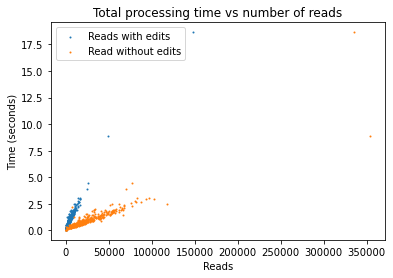

In [180]:
total_reads_and_times_df = total_reads_df.join(total_contig_times_df)

plt.scatter(total_reads_and_times_df.edited, total_reads_and_times_df.seconds, s=1)
plt.scatter(total_reads_and_times_df.no_edits, total_reads_and_times_df.seconds, s=1)

plt.title("Total processing time vs number of reads")
plt.ylabel("Time (seconds)")
plt.xlabel("Reads")
plt.legend(['Reads with edits', 'Read without edits'])

Text(0.5, 1.0, 'Runtime vs number of reads processed')

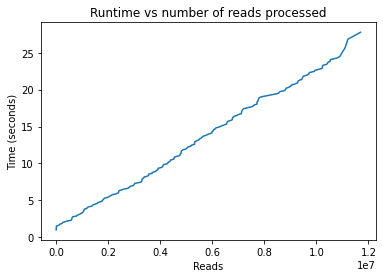

In [181]:
pd.DataFrame.from_dict(total_seconds_for_reads, orient='index').sort_index().plot(legend=False)
plt.xlabel("Reads")
plt.ylabel("Time (seconds)")
plt.title("Runtime vs number of reads processed")

In [182]:
rates = []
for reads, secs in zip(list(total_seconds_for_reads.keys()), list(total_seconds_for_reads.values())):
    rate = reads/secs
    rates.append(rate)

Average of 393009.6829329755 reads/second


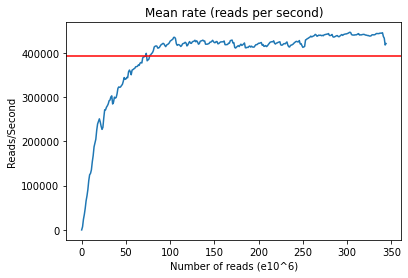

In [183]:
plt.plot(range(len(rates)), rates)
plt.title("Mean rate (reads per second)")
plt.ylabel("Reads/Second")
plt.xlabel("Number of reads (e10^6)")

average_rate = np.mean(rates)
plt.axhline(average_rate, color='r')
print("Average of {} reads/second".format(average_rate))

In [184]:
seconds_per_read = 1/average_rate

In [192]:
import math

reads_per_cell = 50000
total_cells = 10000
total_reads = reads_per_cell * total_cells
print(total_reads)

total_estimated_time = total_reads * seconds_per_read
print('Estimated total time in minutes for {} reads: {} minutes'.format(total_reads, math.ceil(total_estimated_time/60), 3))


500000000
Estimated total time in minutes for 500000000 reads: 22 minutes


# Second loop to get coverage at sites with edits

In [ ]:
# Todo: get all edit info files for each contig and group them by contig, before processing.
# Todo: Multiprocess that too.

In [193]:
from glob import glob

splits = [i.split("/")[-1].split('_edit')[0] for i in glob('{}/edit_info/*'.format(output_folder))]
print("Accessing split bams: {}".format(', '.join(sorted(splits))))

Accessing split bams: 10_000_0_8168438, 10_001_8168438_16336876, 10_002_16336876_24505314, 10_003_24505314_32673752, 10_004_32673752_40842190, 10_005_40842190_49010628, 10_006_49010628_57179066, 10_007_57179066_65347504, 10_008_65347504_73515942, 10_009_73515942_81684380, 10_010_81684380_89852818, 10_011_89852818_98021256, 10_012_98021256_106189694, 10_013_106189694_114358132, 10_014_114358132_122526570, 10_015_122526570_130695008, 11_000_0_7630159, 11_001_7630159_15260318, 11_002_15260318_22890477, 11_003_22890477_30520636, 11_004_30520636_38150795, 11_005_38150795_45780954, 11_006_45780954_53411113, 11_007_53411113_61041272, 11_008_61041272_68671431, 11_009_68671431_76301590, 11_010_76301590_83931749, 11_011_83931749_91561908, 11_012_91561908_99192067, 11_013_99192067_106822226, 11_014_106822226_114452385, 11_015_114452385_122082544, 12_000_0_7508064, 12_001_7508064_15016128, 12_002_15016128_22524192, 12_003_22524192_30032256, 12_004_30032256_37540320, 12_005_37540320_45048384, 12_00

In [ ]:
all_edit_info_for_barcodes = []

for split in splits:    
    contig = split.split("_")[0]
    print(split)
    reads_skipped = 0
    
    barcode_to_coverage_dict = defaultdict()    
    #contig_length = contig_lengths_dict.get(contig)
    
    barcode_to_coverage_dict = defaultdict()
    edit_info_file = '{}/edit_info/{}_edit_info.tsv'.format(output_folder, split)
    edit_info = pd.read_csv(edit_info_file, sep='\t')
    print("num rows in {}: {}".format(edit_info_file, len(edit_info)))
    
    unique_barcodes = sorted(edit_info.barcode.unique())
    print("\tUnique barcodes: {}".format(len(unique_barcodes)))
    bam_subfolder = "{}/split_bams/{}".format(output_folder, contig)

    print("\tCoverage bam is at {}".format(bam_subfolder))
    
    
    for i, barcode in enumerate(unique_barcodes):            
        if i % 100 == 0:
            print('\t\t{}/{}'.format(i, len(unique_barcodes)))
    
        barcode_bam = '{}/{}_{}.bam'.format(bam_subfolder, contig, barcode)
            
        try:
            samfile_for_barcode = pysam.AlignmentFile(barcode_bam, "rb")

            edit_info_for_barcode = edit_info[edit_info.barcode == barcode]
            positions_for_barcode = edit_info_for_barcode.position.tolist()

            coverage = []
            for pos in positions_for_barcode:
                coverage_at_pos = np.sum(samfile_for_barcode.count_coverage(contig, pos-1, pos))
                coverage.append(coverage_at_pos)

            edit_info_for_barcode['coverage'] = coverage
            all_edit_info_for_barcodes.append(edit_info_for_barcode)
        except Exception as e:
            print('Fail', barcode_bam, e)
    
    

16_006_36827916_42965902
num rows in /projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger/edit_info/16_006_36827916_42965902_edit_info.tsv: 12844
	Unique barcodes: 1008
	Coverage bam is at /projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger/split_bams/16
		0/1008


/home/ekofman/new_anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


		100/1008
		200/1008
		300/1008
		400/1008
		500/1008
		600/1008
		700/1008
		800/1008
		900/1008
		1000/1008
10_014_114358132_122526570
num rows in /projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger/edit_info/10_014_114358132_122526570_edit_info.tsv: 6782
	Unique barcodes: 887
	Coverage bam is at /projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger/split_bams/10
		0/887
		100/887
		200/887
		300/887
		400/887
		500/887
		600/887
		700/887
		800/887
X_014_149652398_160341855
num rows in /projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger/edit_info/X_014_149652398_160341855_edit_info.tsv: 6914
	Unique barcodes: 996
	Coverage bam is at /projects/ps-yeolab3/ekofman/sailor2/scripts/check_against_pileup_all_cells_threaded_outs_bigger/split_bams/X
		0/996
		100/996
		200/996
		300/996
		400/996
		500/996
		600/996
		700/996
		800/996
		900/996
Y_011_63074484

In [ ]:
all_edit_info = pd.concat(all_edit_info_for_barcodes)

In [ ]:
all_edit_info

In [509]:
len(all_edit_info)

320

In [510]:
all_edit_info['contig'] = all_edit_info.contig.astype(str)

In [511]:
all_edit_info = all_edit_info.drop_duplicates()

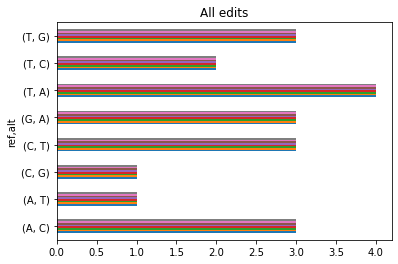

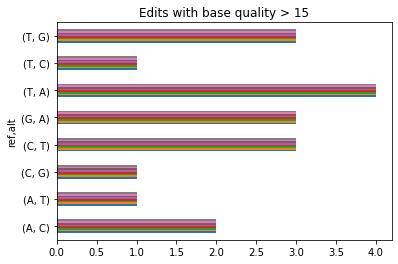

In [512]:
all_edit_info.groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
plt.title("All edits")

base_quality_thresh = 15
all_edit_info[all_edit_info.base_quality > base_quality_thresh].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
plt.title("Edits with base quality > {}".format(base_quality_thresh))

all_edit_info_filtered = all_edit_info[all_edit_info.base_quality > base_quality_thresh]


In [513]:
example_new_ct =  all_edit_info_filtered[(all_edit_info_filtered.ref == 'C') & (all_edit_info_filtered.alt == 'T')].sort_values('position')

In [514]:
len(example_new_ct)

3

In [515]:
example_new_ct

,barcode,contig,position,ref,alt,read_id,strand,dist_from_end,base_quality,coverage
248,AACCAACGTTCTAAGC-1,1,171173372,C,T,A01535:287:H3JJHDSX7:1:2357:31494:31109,-,22,37,1
12252,AACCAACGTTCTAAGC-1,1,178480162,C,T,A01535:287:H3JJHDSX7:1:1271:31910:16673,+,33,37,1
14001,AACCAACGTTCTAAGC-1,1,180227733,C,T,A01535:287:H3JJHDSX7:1:1474:13349:26741,-,93,37,0


# Cells that do have STAMP expressed versus don't...?

In [516]:
stamp_expression_path = \
'/projects/ps-yeolab3/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_combined/\
4.1_cells_with_middling_stamp/stamp_expression_for_all_used_cells.tsv'

In [517]:
stamp_expression_df = pd.read_csv(stamp_expression_path, sep='\t', index_col=0)

<AxesSubplot:>

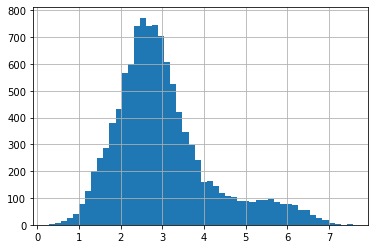

In [518]:
stamp_expression_df.Stamp.hist(bins=50)

0
1
2
3


IndexError: index 0 is out of bounds for axis 0 with size 0

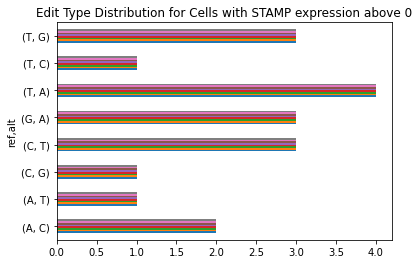

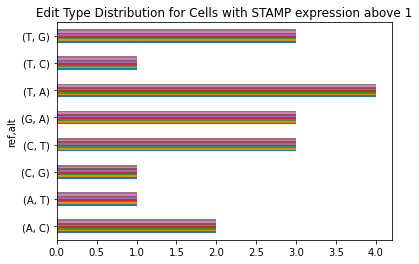

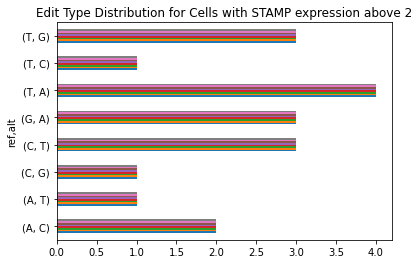

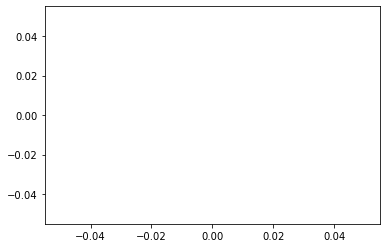

In [519]:
for thresh in [0, 1, 2, 3, 4, 5, 6, 6.5]:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp > thresh].index
    
    all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
    plt.title("Edit Type Distribution for Cells with STAMP expression above {}".format(thresh))

In [ ]:
for thresh in [1.5,2, 3, 4, 5, 6]:
    print(thresh)
    barcodes_at_stamp_thresh = stamp_expression_df[stamp_expression_df.Stamp < thresh].index
    
    all_edit_info_filtered[
        all_edit_info_filtered.barcode.isin(barcodes_at_stamp_thresh)].groupby(['ref', 'alt']).count().plot(kind='barh', legend=False)
    plt.title("Edit Type Distribution for Cells with STAMP expression below {}".format(thresh))

# Extract only reads for a barcode

In [63]:
# Get edits for barcode
barcode = 'AAACCCAAGATTGCGG'


example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])


In [64]:

comparison_vals = []
overlapping_by_contig = {}
old_for_contig = {}
new_for_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    old_for_contig[contig] = example_old_ct_for_contig
    new_for_contig[contig] = example_new_ct_for_contig
    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


NameError: name 'contigs' is not defined

# Which sites are we recovering?

In [79]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

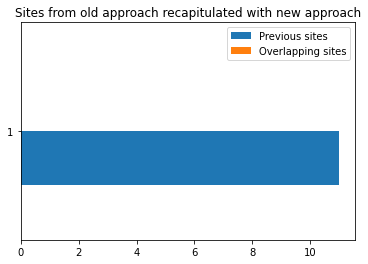

In [80]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].head(22).plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [81]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: nan
